[← Back to Index](../index)

# Frequency analysis

Periodic signals are composed of sinusoidal waveforms of one or more frequencies. Is there a way to extract and measure the strength of these underlying frequencies? Yes! This is called **Fourier analysis**, a family of mathematical techniques to transform a signal from the time domain to the frequency domain.

<img src="https://upload.wikimedia.org/wikipedia/commons/6/61/FFT-Time-Frequency-View.png" width="400"></img>
<center><caption><strong>Figure.</strong> View of a signal in the time and frequency domain</caption></center>

## Resources

### Interactive tutorials
- One of the best resources I've found is this fantastic interactive guide by Jez Swanson: [An Interactive Introduction to Fourier Transforms](http://www.jezzamon.com/fourier/index.html). Seriously, stop right now, and visit this website! :)
- Jack Schaelder provides another interactive guide on the [Fourier Transform](https://jackschaedler.github.io/circles-sines-signals/dft_introduction.html) as part of his [Compact Primer on Digital Signal Processing](https://jackschaedler.github.io/circles-sines-signals/index.html).
- [Chapter 4. Frequency and the Fast Fourier Transform](https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html), Elegant SciPy by Juan Nunez-Iglesias, Stéfan van der Walt, Harriet Dashnow
- For a more mathematical take, try 3Blue1Brown's [But What is the Fourier Transform? A Visual Introduction](https://youtu.be/spUNpyF58BY) (and incidentally, 3Blue1Brown produces the best math videos on the Internet!).

### Book chapters
- [Chapter 8: The Discrete Fourier Transform (DFT)](http://www.dspguide.com/CH8.PDF), The Scientist and Engineer's Guide to Digital Signal Processing, Steven W. Smith, Ph.D.
- [Chapter 9: Applications of the DFT](http://www.dspguide.com/CH9.PDF), The Scientist and Engineer's Guide to Digital Signal Processing, Steven W. Smith, Ph.D.
- [Chapter 12: The Fast Fourier Transform (FFT)](http://www.dspguide.com/CH12.PDF), The Scientist and Engineer's Guide to Digital Signal Processing, Steven W. Smith
- (More mathematically focused) [Chapter 6: Spectral Analysis](http://faculty.washington.edu/stiber/pubs/Signal-Computing/Signal%20Computing.pdf), Stiber, Stiber, and Larson, 2020
- Cooley, James W., and John W. Tukey, 1965, “An algorithm for the machine calculation of complex Fourier series,” Math. Comput. 19: 297-301.



# Main Imports

In [1]:
import matplotlib.pyplot as plt # matplot lib is the premiere plotting lib for Python: https://matplotlib.org/
import numpy as np # numpy is the premiere signal handling library for Python: http://www.numpy.org/
import scipy as sp # for signal processing
from scipy import signal
from scipy.spatial import distance
import IPython.display as ipd
import ipywidgets
import librosa
import random
import math
import makelab
from makelab import audio
from makelab import signal

# Utility functions

In [2]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

def get_freq_and_amplitude_csv(freqs, amplitudes):
    '''Convenience function to convert a freq and amplitude array to a csv string'''
    freq_peaks_with_amplitudes_csv = ""
    for i in range(len(freqs)):
        freq_peaks_with_amplitudes_csv += f"{freqs[i]} Hz ({amplitudes[i]:0.2f})"
        if i + 1 is not len(freqs):
            freq_peaks_with_amplitudes_csv += ", "
    return freq_peaks_with_amplitudes_csv

def get_top_n_frequency_peaks(n, freqs, amplitudes, min_amplitude_threshold = None):
    ''' Finds the top N frequencies and returns a sorted list of tuples (freq, amplitudes) '''
    
    # Use SciPy signal.find_peaks to find the frequency peaks
    # TODO: in future, could add in support for min horizontal distance so we don't find peaks close together
    fft_peaks_indices, fft_peaks_props = sp.signal.find_peaks(amplitudes, height = min_amplitude_threshold)
    
    freqs_at_peaks = freqs[fft_peaks_indices]
    amplitudes_at_peaks = amplitudes[fft_peaks_indices]
    
    if n < len(amplitudes_at_peaks):
        ind = np.argpartition(amplitudes_at_peaks, -n)[-n:] # from https://stackoverflow.com/a/23734295
        ind_sorted_by_coef = ind[np.argsort(-amplitudes_at_peaks[ind])] # reverse sort indices
    else:
        ind_sorted_by_coef = np.argsort(-amplitudes_at_peaks)

    return_list = list(zip(freqs_at_peaks[ind_sorted_by_coef], amplitudes_at_peaks[ind_sorted_by_coef]))
    return return_list

def get_top_n_frequencies(n, freqs, amplitudes, min_amplitude_threshold = None):
    '''
    Gets the top N frequencies: a sorted list of tuples (freq, amplitudes)
    
    This is a rather naive implementation. For a better implementation, see get_top_n_frequency_peaks
    
    '''
    
    #print(amplitudes)
    if min_amplitude_threshold is not None:
        amplitude_indices = np.where(amplitudes >= min_amplitude_threshold)
        amplitudes = amplitudes[amplitude_indices]
        freqs = freqs[amplitude_indices]
        
    if n < len(amplitudes):
        ind = np.argpartition(amplitudes, -n)[-n:] # from https://stackoverflow.com/a/23734295
        ind_sorted_by_coef = ind[np.argsort(-amplitudes[ind])] # reverse sort indices
    else:
        ind_sorted_by_coef = np.argsort(-amplitudes)

    return_list = list(zip(freqs[ind_sorted_by_coef], amplitudes[ind_sorted_by_coef]))
    return return_list

def calc_and_plot_xcorr_dft_with_ground_truth(s, sampling_rate, 
                                              time_domain_graph_title = None,
                                              xcorr_freq_step_size = None,
                                              xcorr_comparison_signal_length_in_secs = 0.5,
                                              normalize_xcorr_result = True,
                                              include_annotations = True,
                                              minimum_freq_amplitude = 0.08,
                                              y_axis_amplitude = True,
                                              fft_pad_to = None):
    '''
    Calculates and plots a "brute force" DFT using cross correlation along with a ground truth
    DFT using matplotlib's magnitude_spectrum method.
    
    Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        xcorr_comparison_signal_length_in_secs (float): specifies the time for the comparison signals (500ms is default)
        xcorr_freq_step_size (float): the step size to use for enumerating frequencies
            for the cross-correlation method of DFT. For example, setting this to 0.1, will enumerate
            frequencies with a step size of 0.1 from 1 to nyquist_limit. If None, defaults to step
            size of 1
        normalize_xcorr_result (boolean): if True, defaults to normalization. Otherwise, not.
        y_axis_amplitude (boolean): if True, normalizes the spectrum transform to show amplitudes
    '''
    
    total_time_in_secs = len(s) / sampling_rate
    
    # Enumerate through frequencies from 1 to the nyquist limit
    # and run a cross-correlation comparing each freq to the signal
    freq_and_correlation_results = [] # tuple of (freq, max correlation result)
    nyquist_limit = sampling_rate // 2
    
    freq_step_size = 1
    freq_seq_iter = range(1, nyquist_limit)
    if xcorr_freq_step_size is not None:
        freq_seq_iter = np.arange(1, nyquist_limit, xcorr_freq_step_size)
        freq_step_size = xcorr_freq_step_size
    
    progress_bar = ipywidgets.FloatProgress(value=1, min=1, max=nyquist_limit)
    ipd.display(progress_bar)
    num_comparisons = 0
    for test_freq in freq_seq_iter:
        signal_to_test = makelab.signal.create_sine_wave(test_freq, 
                                                         sampling_rate, 
                                                         xcorr_comparison_signal_length_in_secs)
        correlate_result = np.correlate(s, signal_to_test, 'full')

        # Add in the tuple of test_freq, max correlation result value
        freq_and_correlation_results.append((test_freq, np.max(correlate_result)))
        
        num_comparisons += 1
        progress_bar.value += freq_step_size

    # The `freq_and_correlation_results` is a list of tuple results with (freq, correlation result)
    # Unpack this tuple list into two separate lists freqs, and correlation_results
    correlation_freqs, correlation_results = list(zip(*freq_and_correlation_results))
    
    correlation_freqs = np.array(correlation_freqs)
    correlation_results = np.array(correlation_results)
    correlation_results_original = correlation_results
    
    cross_correlation_ylabel = "Cross-correlation result"
    if normalize_xcorr_result:
        correlation_results = correlation_results / (nyquist_limit - 1)
        cross_correlation_ylabel += " (normalized)"
        
    if y_axis_amplitude:
        correlation_results = (correlation_results_original / (nyquist_limit - 1)) * 2
        cross_correlation_ylabel = "Frequency Amplitude"

    # Plotting
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))

    # Plot the signal in the time domain
    makelab.signal.plot_signal_to_axes(axes[0], s, sampling_rate, title = time_domain_graph_title)
    axes[0].set_title(axes[0].get_title(), y=1.2)

    # Plot the signal correlations (our brute force approach)
    axes[1].plot(correlation_freqs, correlation_results)
    axes[1].set_title("Brute force DFT using cross correlation")
    axes[1].set_xlabel("Frequency")
    axes[1].set_ylabel(cross_correlation_ylabel)

    # Plot the "ground truth" via an FFT
    # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.magnitude_spectrum.html
    # Use zero padding to obtain a more accurate estimate of the sinusoidal amplitudes
    # See: https://www.mathworks.com/help/signal/ug/amplitude-estimation-and-zero-padding.html
    if fft_pad_to is None:
        fft_pad_to = len(s) * 4
    elif fft_pad_to == 0:
        fft_pad_to = None
    
    fft_spectrum, fft_freqs, line = axes[2].magnitude_spectrum(s, Fs = sampling_rate, color='r',
                                                                   pad_to = fft_pad_to)
    if y_axis_amplitude:
        # By default, the magnitude_spectrum plots half amplitudes (perhaps because it's
        # showing only one-half of the full FFT (the positive frequencies). But there is not
        # way to control this to show full amplitudes by passing in a normalization parameter
        # So, instead, we'll do it by hand here (delete the old line and plot the normalized spectrum)
        line.remove()
        fft_spectrum = np.array(fft_spectrum) * 2
        axes[2].plot(fft_freqs, fft_spectrum, color = 'r')
        axes[2].set_ylabel("Frequency Amplitude")
    
    axes[2].set_title("Using built-in FFT via matplotlib.pyplot.magnitude_spectrum")

    # Find the number of peaks
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks_cwt.html
    # Du et al., Improved Peak Detection, Bioinformatics: https://academic.oup.com/bioinformatics/article/22/17/2059/274284
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
    xcorr_dft_peaks_indices, xcorr_dft_peaks_props = sp.signal.find_peaks(correlation_results, height = minimum_freq_amplitude)
    xcorr_freq_peaks = correlation_freqs[xcorr_dft_peaks_indices]
    xcorr_freq_peak_amplitudes = correlation_results[xcorr_dft_peaks_indices]
    xcorr_freq_peaks_csv = ", ".join(map(str, xcorr_freq_peaks))
    xcorr_freq_peaks_with_amplitudes_csv = get_freq_and_amplitude_csv(xcorr_freq_peaks, xcorr_freq_peak_amplitudes)
    xcorr_freq_peaks_array_str = [f"{freq} Hz" for freq in xcorr_freq_peaks]
    
    fft_peaks_indices, fft_peaks_props = sp.signal.find_peaks(fft_spectrum, height = minimum_freq_amplitude)
    fft_freq_peaks = fft_freqs[fft_peaks_indices]
    fft_freq_peaks_amplitudes = fft_spectrum[fft_peaks_indices]
    fft_freq_peaks_csv = ", ".join(map(str, fft_freq_peaks))
    fft_freq_peaks_with_amplitudes_csv = get_freq_and_amplitude_csv(fft_freq_peaks, fft_freq_peaks_amplitudes)
    fft_freq_peaks_array_str = [f"{freq} Hz" for freq in fft_freq_peaks]
    
    # Print out frequency analysis info and annotate plots
    if include_annotations:
        axes[1].plot(xcorr_freq_peaks, xcorr_freq_peak_amplitudes, linestyle='None', marker="x", color="red", alpha=0.8)
        for i in range(len(xcorr_freq_peaks)):
            axes[1].text(xcorr_freq_peaks[i] + 2, xcorr_freq_peak_amplitudes[i], f"{xcorr_freq_peaks[i]} Hz", color="red")
            
        axes[2].plot(fft_freq_peaks, fft_freq_peaks_amplitudes, linestyle='None', marker="x", color="black", alpha=0.8)
        for i in range(len(fft_freq_peaks)):
            axes[2].text(fft_freq_peaks[i] + 2, fft_freq_peaks_amplitudes[i], f"{fft_freq_peaks[i]} Hz", color="black")
    
    print("**Brute force cross-correlation DFT**")
    print(f"Num cross correlations: {num_comparisons}")
    print(f"Frequency step resolution for cross correlation: {freq_step_size}")
    print(f"Found {len(xcorr_dft_peaks_indices)} freq peak(s) at: {xcorr_freq_peaks_csv} Hz")
    print(f"The minimum peak amplitude threshold set to: {minimum_freq_amplitude}")
    print(f"Freq and amplitudes: {xcorr_freq_peaks_with_amplitudes_csv} Hz")

    print("")
    print("**Ground truth FFT**")
    print(f"Num FFT freq bins: {len(fft_freqs)}")
    print(f"FFT Freq bin spacing: {fft_freqs[1] - fft_freqs[0]}")
    print(f"Found {len(fft_peaks_indices)} freq peak(s) at: {fft_freq_peaks_csv} Hz")
    print(f"The minimum peak amplitude threshold set to: {minimum_freq_amplitude}")
    print(f"Freq and amplitudes: {fft_freq_peaks_with_amplitudes_csv} Hz")
    #print(fft_freqs[fft_peaks_indices] + "Hz")
   
    fig.tight_layout(pad=2)
    return (fig, axes, correlation_freqs, correlation_results, fft_freqs, fft_spectrum)

# The composition of periodic signals
In the early 1800s, Fourier claimed that any continuous periodic signal could be represented by the sum of appropriately selected sinusoidal waves ([Smith, Chapter 8](http://www.dspguide.com/CH8.PDF)). And though there are a few nuances—how to represent signals with strong corners like square waves—he was right!

Check out the animation below from [Jez Swanson](http://www.jezzamon.com/fourier/index.html), which shows a square wave (in dark blue) being approximated by summing a large number of sinusoidal waves. Understanding this concept will give you intuition for how a Fourier transform works, which extracts the underlyin frequencies from periodic signals.

<img src="assets/movies/SignalComposition_SquareWaves_Jezzamon_optimized.gif" width=400 alt="Animation shows a square wave being approximated by sinusoidal waves"/>
<center>A square wave (in dark blue) being approximated by summing sinusoidal waves. From <a href="http://www.jezzamon.com/fourier/index.html">Jez Swanson</a></center>

As another example, watch this [video](https://youtu.be/fCAZ7jcO-vc?t=685) by Professor Van Veen, which shows how to analyze and then synthesize a saxophone simply by summing sinusoidal waveforms consiting of a saxophone's frequency components.

## Synthesizing signals by summing sinusoids

Let's try something similar: let's play a simple music chord by summing up the underlying waveforms. We'll start by creating sinusoids corresponding to [piano key](https://en.wikipedia.org/wiki/Piano_key_frequencies) frequencies:

- $C_4$ ([Middle C](https://en.wikipedia.org/wiki/C_(musical_note)#Middle_C) )) at 261.6256 Hz
- $A_4$ at 440 Hz (often used as a [tuning standard](https://en.wikipedia.org/wiki/A440_(pitch_standard)) for calibrating musical instruments)
- $C_5$ ([Tenor C](https://en.wikipedia.org/wiki/C_(musical_note)#Designation_by_octave) )) at 523.2511 Hz
- $A_5$ at 880Hz.

And then we'll sum them together to synthesize a chord.

We will be creating perfect sine waves, so our waveforms will **not** sound like a piano. They will sound, well, artificial (though not as bad as our piezo speakers, ha!). Why? Because our signals will lack harmonics and timbre—the attributes of sound that give our real-world instruments richness and individuality.

### C4 (Middle C) at 261.6256 Hz

We will begin by creating a 500ms waveform with a middle C frequency (261.6256Hz) and then we'll create 500ms waveforms for the other notes ($A_4$, $C_5$, and $A_5$). 

Because we are using computers, we cannot synthesize a **continuous** ~261.6 Hz waveform—we are limited to creating a digital sample. So, we need to also select a sampling rate.

But what should we use for this? Recall the Nyquist sampling theorem, which states that to properly capture a signal, we need at least **two samples** per sampling period of the **highest** frequency component in our signal. In our example, the highest frequency is $A_5$ (880Hz). Thus, the minimum sampling frequency to capture this signal would be $2 * 880Hz = 1,760Hz$ (the Nyquist rate). 

However, while 1,760Hz is the absolute minimum rate, it poses two problems for us: first, to play sounds on Chrome, we need a minimum sampling rate of 3,000Hz (Firefox seems to work at any sampling rate); second, at 1,760Hz, the visualizations of each signal are not particularly high fidelity.

So, for the examples below, we set the `sampling_rate`to ~10x the Nyquist rate (16,000Hz). Feel free to play around with different values if you are curious, however!

Let's begin by creating the middle C signal:

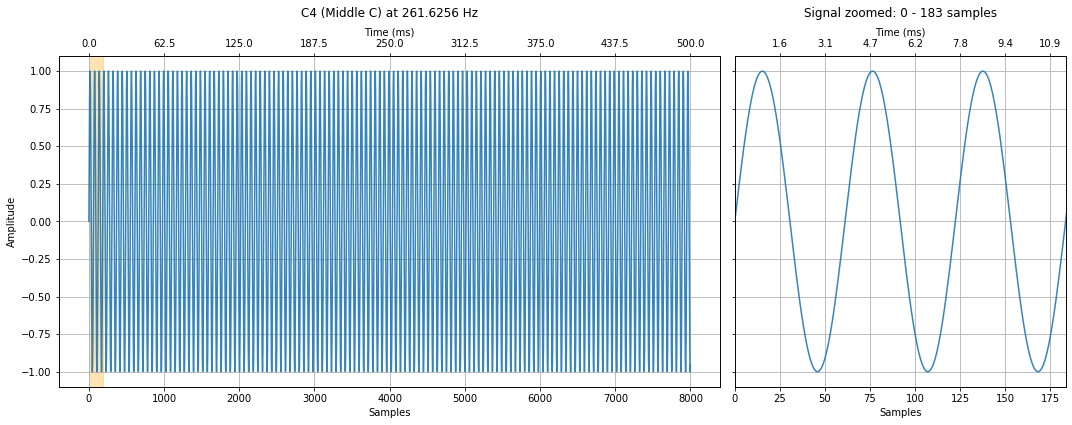

In [3]:
# Create and graph the C4 (Middle C) at 261.6256 Hz signal 
# Make sure you also play the signal to hear it! Recall that higher frequencies
# will have higher pitch (and even 880Hz will seem "high" to our ears)

sampling_rate = 16000 # feel free to change this (see above)
freq = 261.6256 # https://en.wikipedia.org/wiki/Piano_key_frequencies
total_time_in_secs = 0.5 # signal lasts 500ms
c4_signal = makelab.signal.create_sine_wave(freq, sampling_rate, total_time_in_secs)

# We'll show a zoom next to the full signal plot to make it easier to see the waveform
# We'll use the same zoom size (in time) across all four notes so it's easier to compare
zoom_show_num_periods = 3
xlim_zoom = (0, zoom_show_num_periods * 1 / freq * sampling_rate)
title = "C4 (Middle C) at 261.6256 Hz"
makelab.signal.plot_signal(c4_signal, sampling_rate, title = title, xlim_zoom = xlim_zoom)

ipd.Audio(c4_signal, rate=sampling_rate)

### A4 at 440Hz

Create and graph the A4 signal at 440Hz.

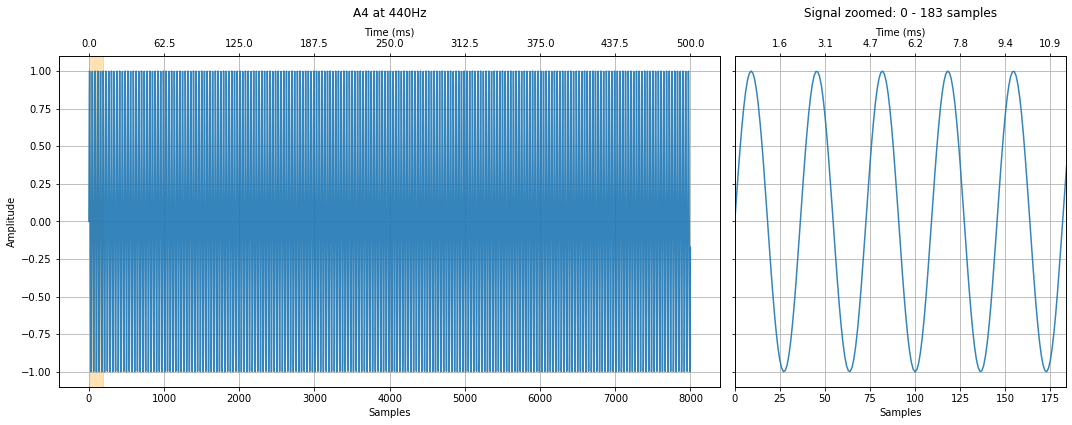

In [4]:
freq = 440 # https://en.wikipedia.org/wiki/Piano_key_frequencies
a4_signal = makelab.signal.create_sine_wave(freq, sampling_rate, total_time_in_secs)

title = "A4 at 440Hz"
makelab.signal.plot_signal(a4_signal, sampling_rate, title = title, xlim_zoom = xlim_zoom)

ipd.Audio(a4_signal, rate=sampling_rate)

### C5 (Tenor C) at 523.2511 Hz

Create and graph the C5 signal at 523.2511Hz.

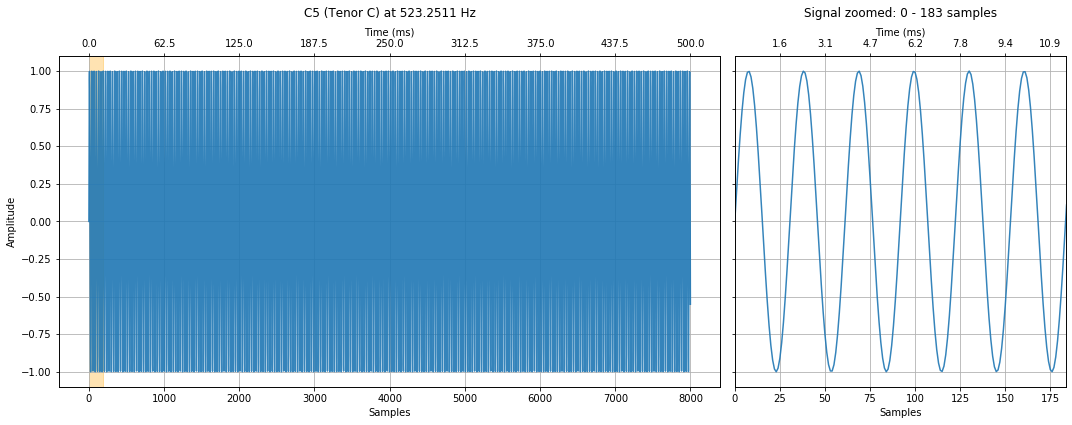

In [5]:
freq = 523.2511 # https://en.wikipedia.org/wiki/Piano_key_frequencies
c5_signal = makelab.signal.create_sine_wave(freq, sampling_rate, total_time_in_secs)

title = "C5 (Tenor C) at 523.2511 Hz"
makelab.signal.plot_signal(c5_signal, sampling_rate, title = title, xlim_zoom = xlim_zoom)

ipd.Audio(c5_signal, rate=sampling_rate)

### A5 at 880Hz

Create and graph the A5 signal at 880Hz.

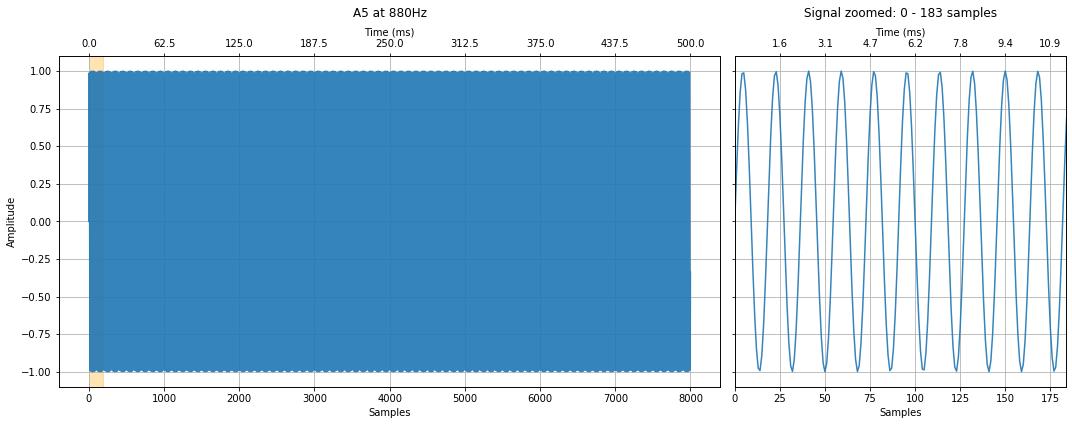

In [6]:
freq = 880 # https://en.wikipedia.org/wiki/Piano_key_frequencies
a5_signal = makelab.signal.create_sine_wave(freq, sampling_rate, total_time_in_secs)

title = "A5 at 880Hz"
makelab.signal.plot_signal(a5_signal, sampling_rate, title = title, xlim_zoom = xlim_zoom)

ipd.Audio(a5_signal, rate=sampling_rate)

### Summing the signals together (playing a chord)

Now, how do we create the chord? Well, we simply sum the signals together.

#### C4, C5 Chord
First, let's just play the C notes together. Listen to the resulting chord and observe/analyze the resulting waveform. What do you hear? What do you see?

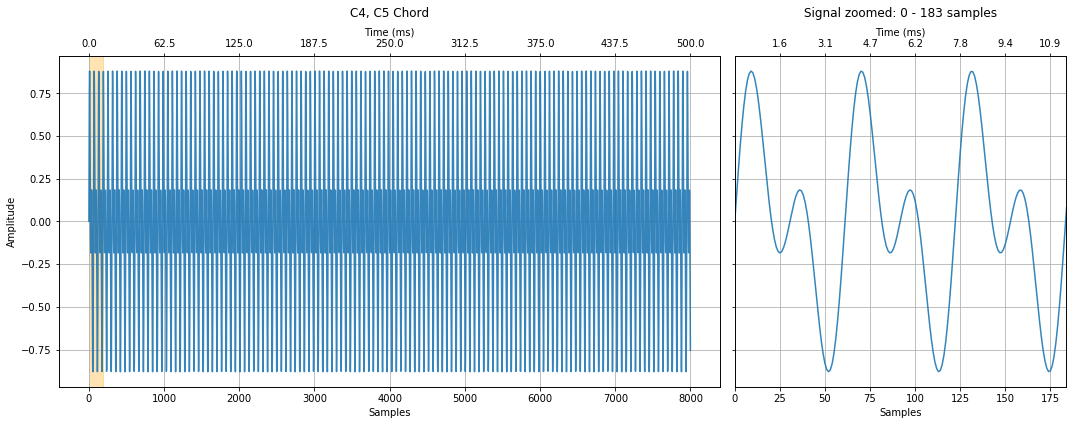

In [7]:
c4c5_chord_signal = c4_signal + c5_signal
c4c5_chord_signal = c4c5_chord_signal / 2 # normalize to -1 to 1 by dividing by num of signals
title = "C4, C5 Chord"
makelab.signal.plot_signal(c4c5_chord_signal, sampling_rate, title = title, xlim_zoom = xlim_zoom)

ipd.Audio(c4c5_chord_signal, rate=sampling_rate)

#### A4, A5 Chord
Now the A notes together.

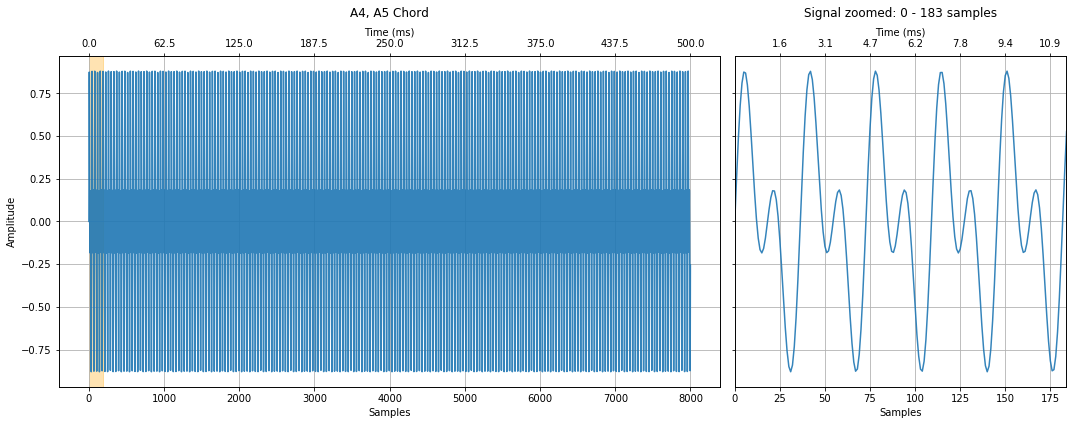

In [8]:
a4a5_chord_signal = a4_signal + a5_signal
a4a5_chord_signal = a4a5_chord_signal / 2 # normalize to -1 to 1 by dividing by num of signals
title = "A4, A5 Chord"
makelab.signal.plot_signal(a4a5_chord_signal, sampling_rate, title = title, xlim_zoom = xlim_zoom)

ipd.Audio(a4a5_chord_signal, rate=sampling_rate)

#### The full C4, A4, C5, A5 chord

Finally, let's play the full chord.

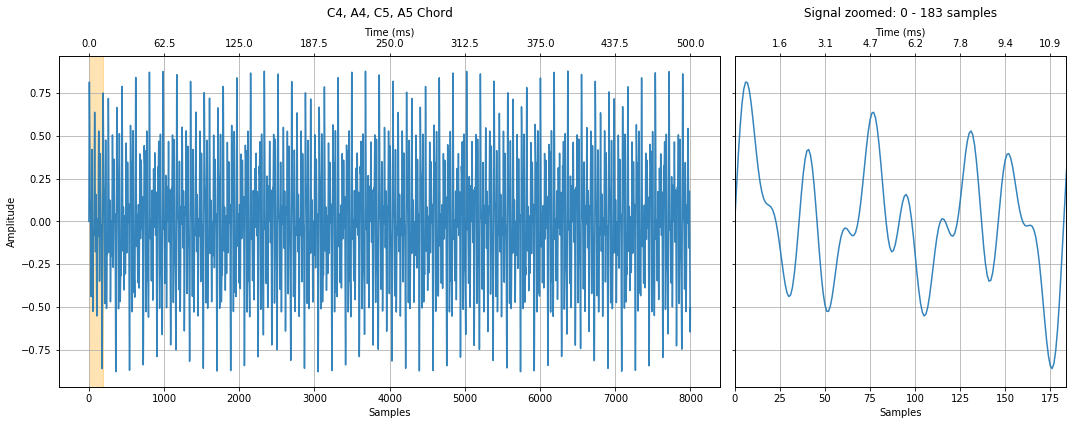

In [9]:
full_chord_signal = c4_signal + a4_signal + c5_signal + a5_signal
full_chord_signal = full_chord_signal / 4 # normalize
title = "C4, A4, C5, A5 Chord"
makelab.signal.plot_signal(full_chord_signal, sampling_rate, title = title, xlim_zoom = xlim_zoom)

ipd.Audio(full_chord_signal, rate=sampling_rate)

#### Control amplitudes

You can control how **much** of each frequency (note) is in the signal by multiplying in amplitudes. For example, let's emphasize the C4 signal over the other signals. 

Note that I'm continuing to normalize the signal to have amplitides between -1 and 1 by selecting amplitudes that sum to one (however, the `ipd.Audio` widget doesn't seem to care—so it's probably doing its own normalization if signal amplitudes exceed -1 and 1).

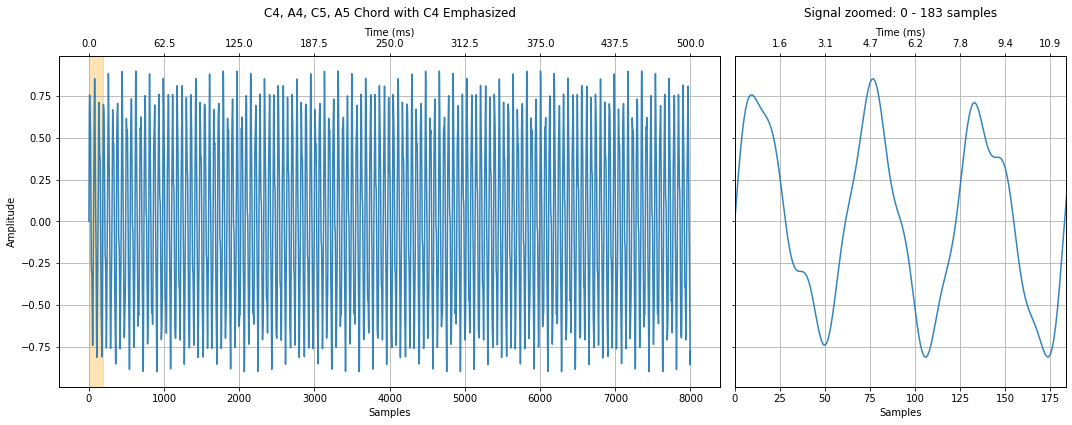

In [10]:
# Notice how we're multiplying in separate amplitudes. Here, we emphasize
# the C4 frequency by multiply 0.7 (vs. 0.1 for the other frequencies)
full_chord_signal2 = 0.7 * c4_signal + 0.1 * a4_signal + 0.1 * c5_signal + 0.1 * a5_signal

title = "C4, A4, C5, A5 Chord with C4 Emphasized"
makelab.signal.plot_signal(full_chord_signal2, sampling_rate, title = title, xlim_zoom = xlim_zoom)

ipd.Audio(full_chord_signal2, rate=sampling_rate)

Here's another version but this time emphasizing the A4 signal.

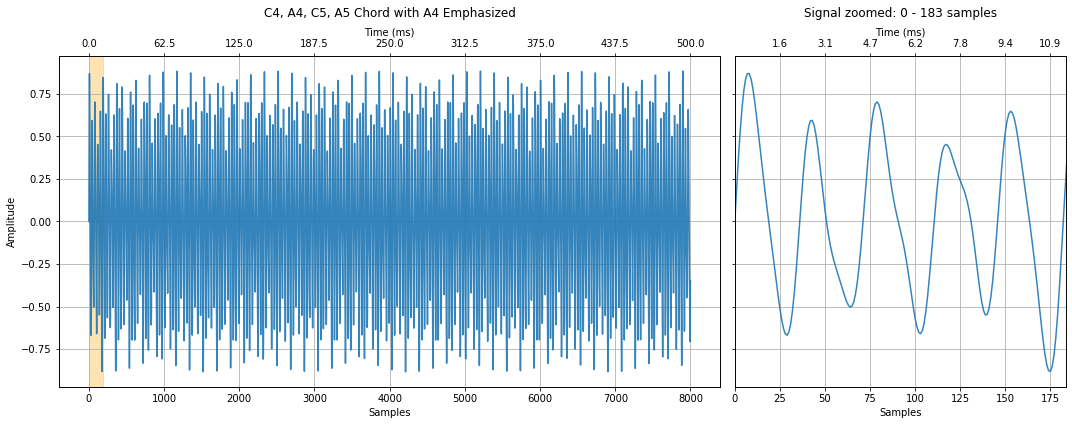

In [11]:
full_chord_signal3 = 0.1333 * c4_signal + 0.6 * a4_signal + 0.1333 * c5_signal + 0.1333 * a5_signal

title = "C4, A4, C5, A5 Chord with A4 Emphasized"
makelab.signal.plot_signal(full_chord_signal3, sampling_rate, title = title, xlim_zoom = xlim_zoom)

ipd.Audio(full_chord_signal3, rate=sampling_rate)

## Exercise: Make and play with your own chords

Below, try making and playing your own chords. We start with a simple C4 chord, which is composed of C, E, and G, but you can change this to whatever you want. And any frequencies will work; however, it's most harmonious to use [musical frequencies](https://en.wikipedia.org/wiki/Piano_key_frequencies).

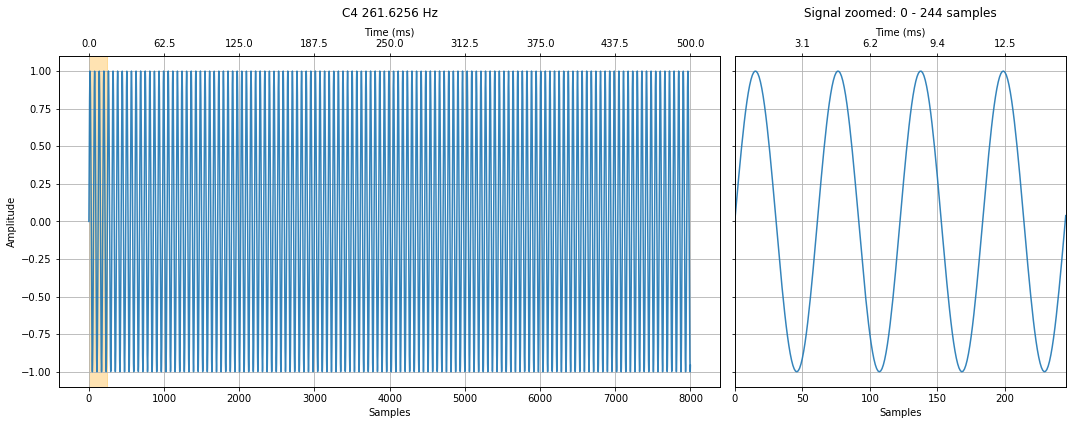

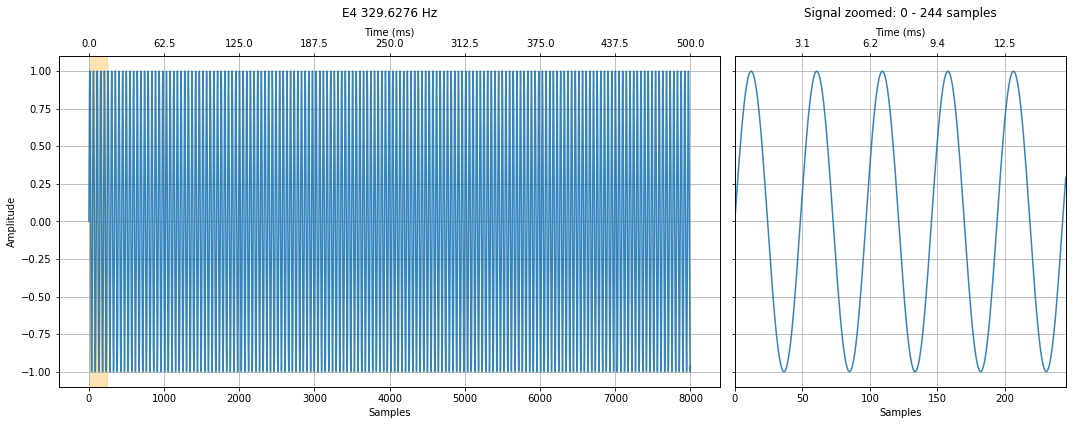

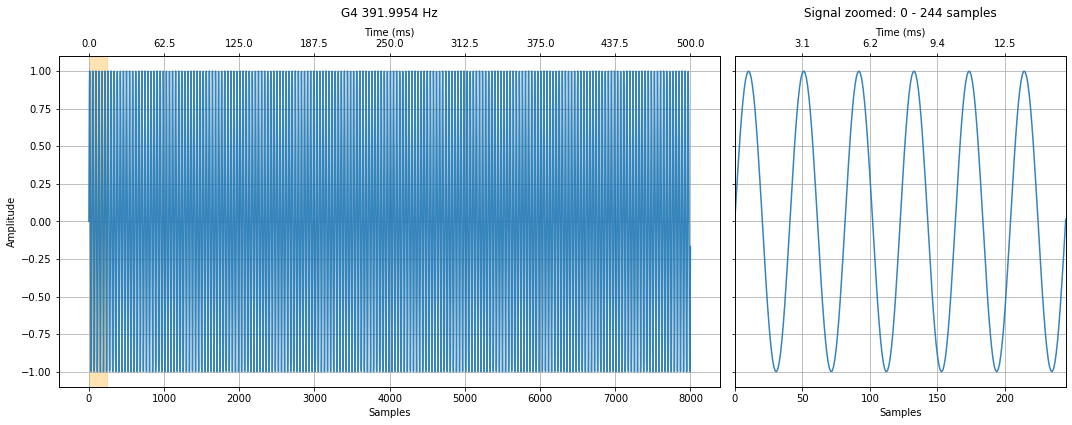

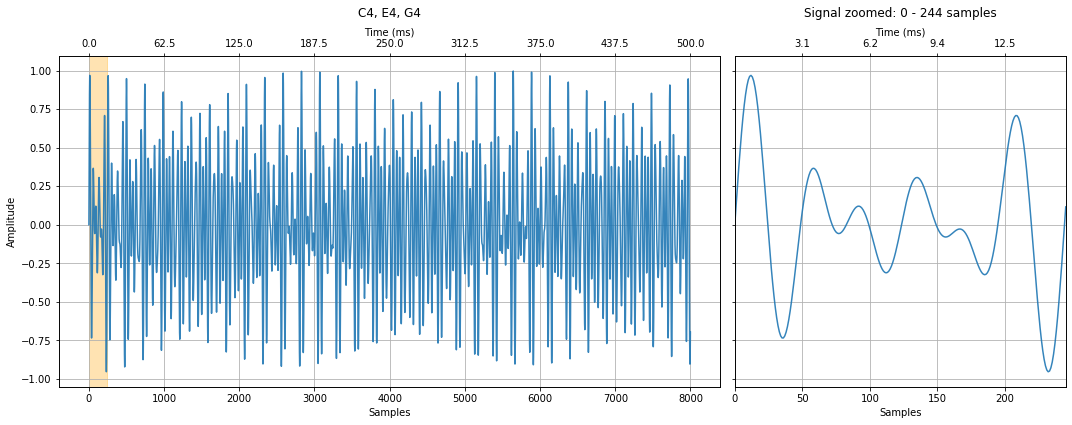

In [12]:
total_time_in_secs = 0.5 # change this to make longer/shorter signals

c4_signal = makelab.signal.create_sine_wave(261.6256, sampling_rate, total_time_in_secs)
e4_signal = makelab.signal.create_sine_wave(329.6276, sampling_rate, total_time_in_secs)
g4_signal = makelab.signal.create_sine_wave(391.9954, sampling_rate, total_time_in_secs)
your_chord = c4_signal + e4_signal + g4_signal
your_chord = your_chord / 3 # normalize by dividing by number of signals to get -1 to 1 waveform

zoom_show_num_periods = 3
xlim_zoom = (0, zoom_show_num_periods * 1 / 195.9977 * sampling_rate)

makelab.signal.plot_signal(c4_signal, sampling_rate, title = "C4 261.6256 Hz", xlim_zoom = xlim_zoom)
makelab.signal.plot_signal(e4_signal, sampling_rate, title = "E4 329.6276 Hz", xlim_zoom = xlim_zoom)
makelab.signal.plot_signal(g4_signal, sampling_rate, title = "G4 391.9954 Hz", xlim_zoom = xlim_zoom)
makelab.signal.plot_signal(your_chord, sampling_rate, title = "C4, E4, G4", xlim_zoom = xlim_zoom)

ipd.Audio(your_chord, rate=sampling_rate)

# Decomposing signals using Fourier analysis

The sub-section above (briefly) showed how we can create complex signals by summing sinusoids; however, can we go the other direction? Can we take a signal and extract it's underlying frequencies?

Yes!

We can do so using the Fourier analysis. More specifically, the **Discrete Fourier Transform (DFT)** (*discrete* because we are using digital samples). 

## Discrete Fourier Transform

A DFT takes, as input, a time-series signal and outputs a frequency domain signal containing the amplitudes of the component waves.

## DFT by correlation

While there are several ways to calculate a DFT—such as solving simultaneous linear equations—let's begin with a "brute force" method using cross-correlation. Yes, the same cross-correlation we learned about in our [previous lesson](https://makeabilitylab.github.io/physcomp/signals/ComparingSignals/index.html).

Recall that before, we used cross-correlation to find or detect a known (or expected) waveform in a signal. DFT by correlation is similar: we are going to enumerate all frequences from 1 Hz to the Nyquist limit and use cross-correlation to check for their existence in an input signal. Yes, this will be slow—that's alot of comparisons!—but the FFT, which we'll explore later, will be much faster.

Let's try it!

### A simple 18 Hz signal

Let's start with a simple 18Hz signal. Can we "detect" the 18Hz signal using a cross-correlation method?

Using cross correlation, we found a 18 Hz signal with a cross correlation of 200.0


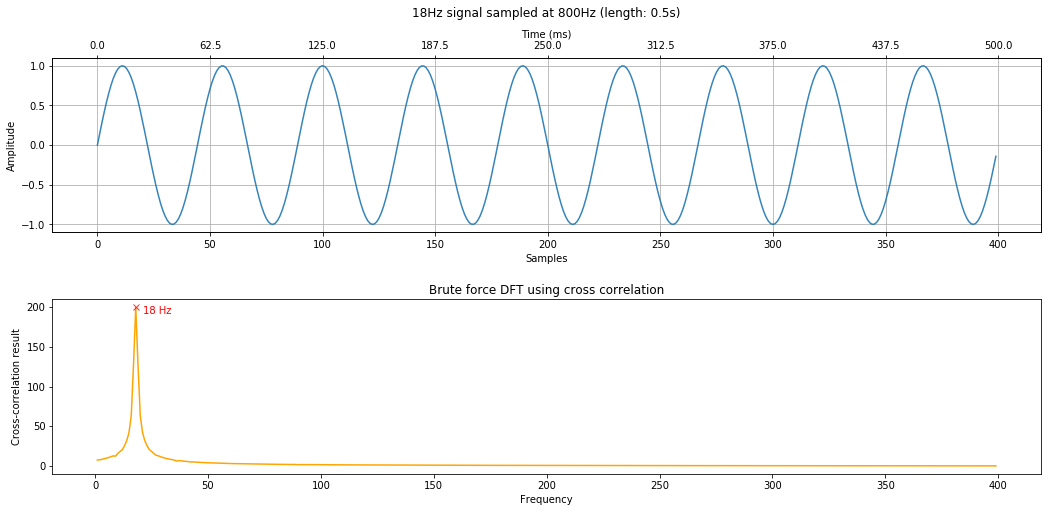

In [10]:
# Generate a 18Hz sine wave with a sampling rate of 800Hz and length 500 ms
sampling_rate = 800
total_time_in_secs = 0.5
signal_18Hz = makelab.signal.create_sine_wave(18, sampling_rate, total_time_in_secs)

# Enumerate through integer frequencies from 1 to the nyquist limit
# and run a cross-correlation comparing each freq to the input signal
freq_and_correlation_results = [] # tuple of (freq, max correlation result)
nyquist_limit = sampling_rate // 2
for test_freq in range(1, nyquist_limit):
    signal_to_test = makelab.signal.create_sine_wave(test_freq, sampling_rate, total_time_in_secs)
    correlate_result = np.correlate(signal_18Hz, signal_to_test, 'full')
    
    # Append results list with tuple of test_freq, max correlation result value
    freq_and_correlation_results.append((test_freq, np.max(correlate_result)))

# The `freq_and_correlation_results` is a list of tuple results with (freq, correlation result)
# Unpack this tuple list into two separate lists freqs, and correlation_results
freqs, correlation_results = list(zip(*freq_and_correlation_results))

# Setup two plots: the first row is our 18Hz signal and the second row is our frequency analysis
fig, axes = plt.subplots(2, 1, figsize=(15, 7.5))

# Plot the 18Hz signal in the time domain
makelab.signal.plot_signal_to_axes(axes[0], signal_18Hz, sampling_rate, 
                                   title=f"18Hz signal sampled at 800Hz (length: {total_time_in_secs}s)")
axes[0].set_title(axes[0].get_title(), y=1.2)

# Plot the signal correlations
axes[1].plot(freqs, correlation_results, color="orange")
axes[1].set_title("Brute force DFT using cross correlation")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Cross-correlation result")

# Identify the top frequency in the signal using argmax
correlation_results = np.array(correlation_results) # convert to a numpy array
xcorr_detected_freq_idx = np.argmax(correlation_results) # get array index location of highest correlation
xcorr_detected_freq = freqs[xcorr_detected_freq_idx]

# Print out the answers
print("Using cross correlation, we found a {} Hz signal with a cross correlation of {}".format(
    xcorr_detected_freq, correlation_results[xcorr_detected_freq_idx]))
axes[1].plot(xcorr_detected_freq, correlation_results[xcorr_detected_freq_idx], marker="x", color="red", alpha=0.8)
axes[1].text(xcorr_detected_freq + 3, correlation_results[xcorr_detected_freq_idx] - 8, 
             f"{xcorr_detected_freq} Hz", color="red")
fig.tight_layout(pad=2)

#### Compare to ground truth

Let's compare our brute force cross-correlation method to ground truth using an FFT.

Using cross correlation, we found a 18 Hz signal with a cross correlation of 200.0
Using an FFT, we found a 18.0 Hz signal with magnitude 0.4999961526485027
Num freq bins: 201
Freq bin spacing: 2.0


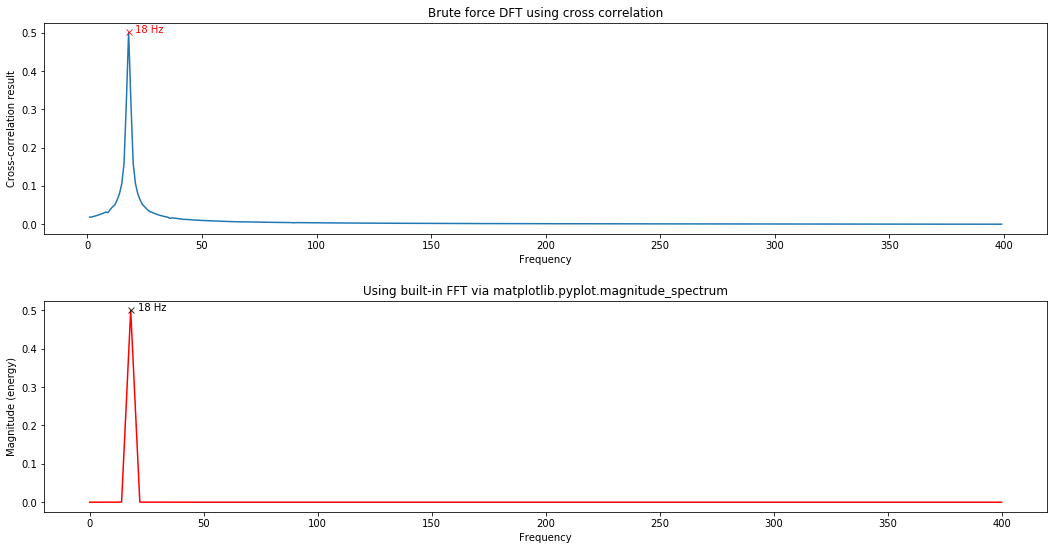

In [14]:
# Plot both our cross correlation result and ground truth
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# normalize by number of comparisons
correlation_results_normalized = np.array(correlation_results) / (nyquist_limit - 1) 

# Plot the signal correlations (our brute force approach)
axes[0].plot(freqs, correlation_results_normalized)
axes[0].set_title("Brute force DFT using cross correlation")
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("Cross-correlation result")
axes[0].plot(xcorr_detected_freq, correlation_results_normalized[xcorr_detected_freq_idx], 
             marker="x", color="red", alpha=0.8)
axes[0].text(xcorr_detected_freq + 3, correlation_results_normalized[xcorr_detected_freq_idx], 
             f"{xcorr_detected_freq} Hz", color="red")

# Plot the "ground truth" via an FFT
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.magnitude_spectrum.html
# The magnitude_spectrum graph's x-axis goes from 0 to nyquist limit
spectrum, freqs_of_spectrum, line = axes[1].magnitude_spectrum(signal_18Hz, Fs = sampling_rate, color='r')
axes[1].set_title("Using built-in FFT via matplotlib.pyplot.magnitude_spectrum")
fig.tight_layout(pad=2)

# Extract and print out stats about the frequency analysis
highest_mag_spectrum_idx = np.argmax(spectrum)
highest_mag = spectrum[highest_mag_spectrum_idx]
freq_at_highest_mag = freqs_of_spectrum[highest_mag_spectrum_idx]

axes[1].plot(freq_at_highest_mag, highest_mag, marker="x", color="black", alpha=0.8)
axes[1].text(freq_at_highest_mag + 3, highest_mag, f"{xcorr_detected_freq} Hz", color="black")

print("Using cross correlation, we found a {} Hz signal with a cross correlation of {}".format(
    xcorr_detected_freq, correlation_results[xcorr_detected_freq_idx]))
print(f"Using an FFT, we found a {freq_at_highest_mag} Hz signal with magnitude {highest_mag}")
print(f"Num freq bins: {len(freqs_of_spectrum)}")
print(f"Freq bin spacing: {freqs_of_spectrum[1] - freqs_of_spectrum[0]}")



### Another simple signal
Let's try another simple signal but this time we'll use the utility function `calc_and_plot_xcorr_dft_with_ground_truth`, which does the same thing as the above cells but scales the y-axis to show the amplitudes of detected frequencies and generally makes it easier for us to analyze and plot signals using our cross-correlation approach.

We'll generate a simple 23Hz signal with length 500ms sampled at 800Hz.

FloatProgress(value=1.0, max=400.0, min=1.0)

**Brute force cross-correlation DFT**
Num cross correlations: 399
Frequency step resolution for cross correlation: 1
Found 1 freq peak(s) at: 23 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 23 Hz (1.00) Hz

**Ground truth FFT**
Num FFT freq bins: 801
FFT Freq bin spacing: 0.5
Found 1 freq peak(s) at: 23.0 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 23.0 Hz (1.00) Hz


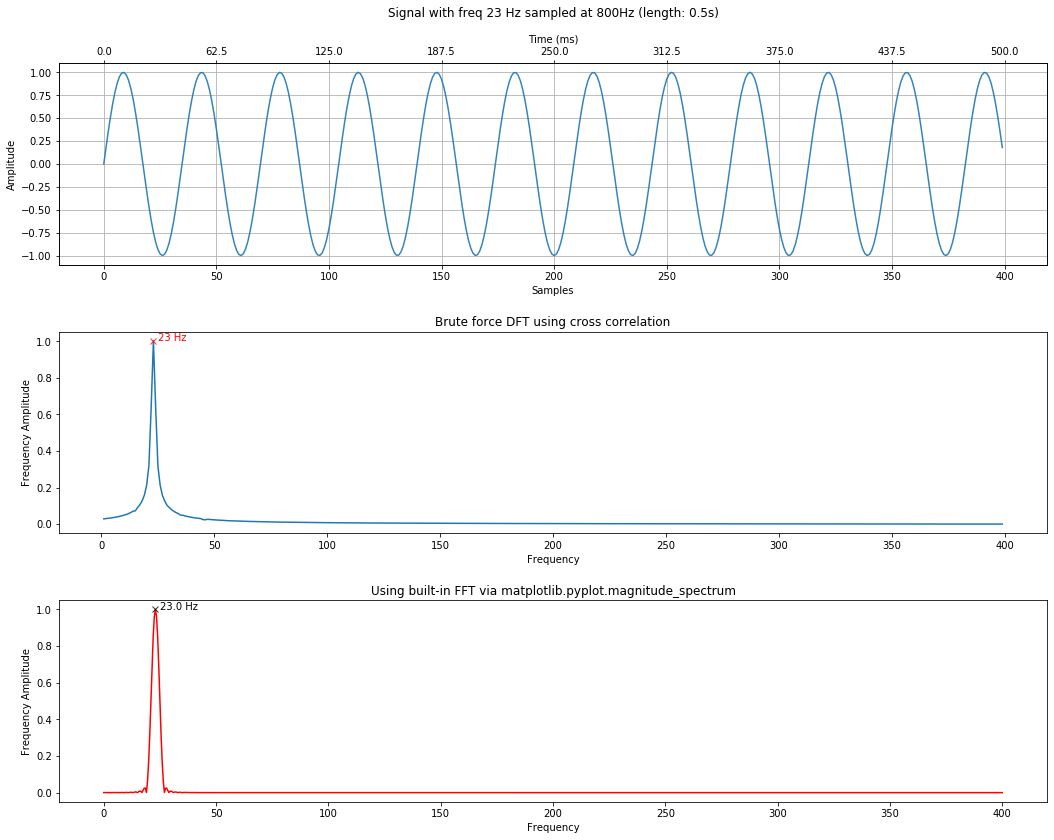

In [15]:
# Generate a 23Hz signal
sampling_rate = 800
total_time_in_secs = 0.5
freq = 23 # feel free to change this to see what happens
signal = makelab.signal.create_sine_wave(freq, sampling_rate, total_time_in_secs)

time_domain_title = f"Signal with freq {freq} Hz sampled at 800Hz (length: {total_time_in_secs}s)"
calc_and_plot_xcorr_dft_with_ground_truth(signal, sampling_rate, 
                                          time_domain_graph_title = time_domain_title);

### Analyzing a composite signal

Let's try with a more complicated signal containing multiple frequencies: 10Hz, 42Hz, and 151Hz. There is nothing special about these frequencies. I literally just chose them arbitrarily.

Below, we'll graph the composite signal, the results of our DFT by cross correlation, and the "ground truth" using an FFT.

FloatProgress(value=1.0, max=400.0, min=1.0)

**Brute force cross-correlation DFT**
Num cross correlations: 399
Frequency step resolution for cross correlation: 1
Found 3 freq peak(s) at: 10, 42, 151 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 10 Hz (1.00), 42 Hz (1.00), 151 Hz (1.00) Hz

**Ground truth FFT**
Num FFT freq bins: 801
FFT Freq bin spacing: 0.5
Found 3 freq peak(s) at: 10.0, 42.0, 151.0 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 10.0 Hz (1.00), 42.0 Hz (1.00), 151.0 Hz (1.00) Hz


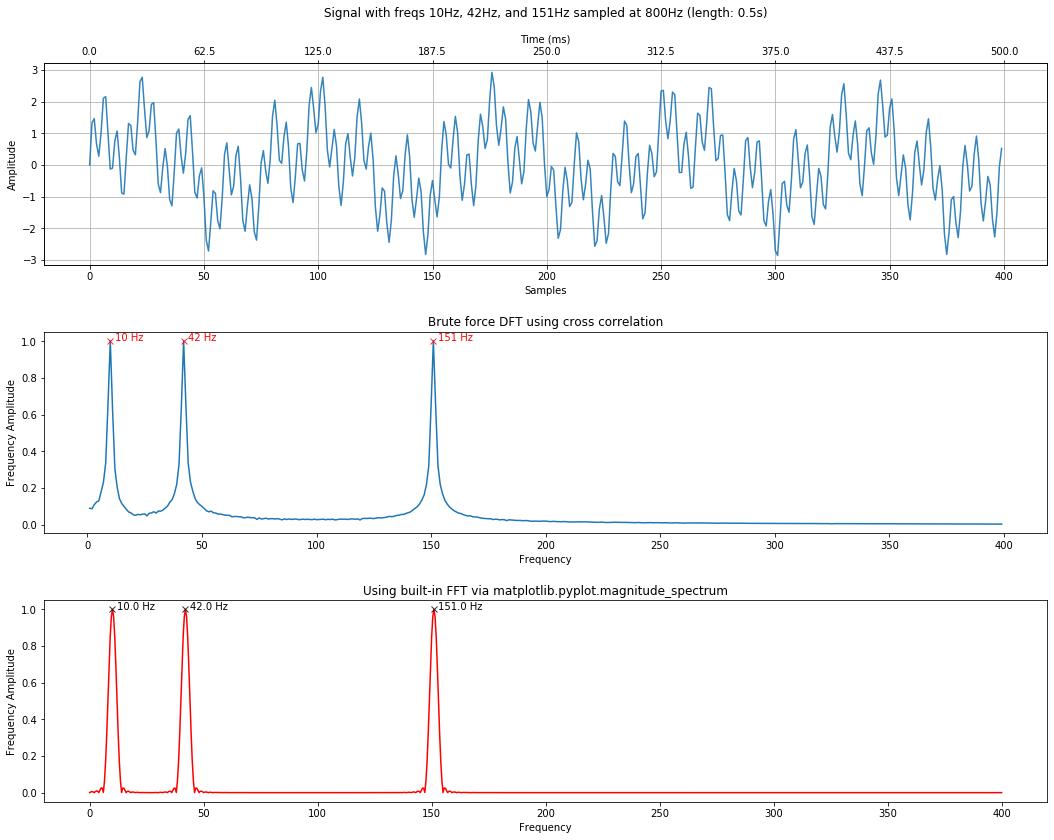

In [16]:
sampling_rate = 800
total_time_in_secs = 0.5

freq1 = 10
freq2 = 42
freq3 = 151

signal1 = makelab.signal.create_sine_wave(freq1, sampling_rate, total_time_in_secs)
signal2 = makelab.signal.create_sine_wave(freq2, sampling_rate, total_time_in_secs)
signal3 = makelab.signal.create_sine_wave(freq3, sampling_rate, total_time_in_secs)

signal_composite = signal1 + signal2 + signal3
time_domain_title = f"Signal with freqs {freq1}Hz, {freq2}Hz, and {freq3}Hz sampled at 800Hz (length: {total_time_in_secs}s)"
calc_and_plot_xcorr_dft_with_ground_truth(signal_composite, sampling_rate, 
                                          time_domain_graph_title = time_domain_title);


### Can we detect underlying amplitudes of signal frequencies?

Can we use a DFT to not just detect that a frequency exists in a signal but the strength of that frequency?

Yes!

Let's try it.

#### Mixing different amplitudes

FloatProgress(value=1.0, max=400.0, min=1.0)

**Brute force cross-correlation DFT**
Num cross correlations: 399
Frequency step resolution for cross correlation: 1
Found 3 freq peak(s) at: 10, 42, 151 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 10 Hz (0.80), 42 Hz (0.11), 151 Hz (0.10) Hz

**Ground truth FFT**
Num FFT freq bins: 801
FFT Freq bin spacing: 0.5
Found 3 freq peak(s) at: 10.0, 42.0, 151.0 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 10.0 Hz (0.80), 42.0 Hz (0.10), 151.0 Hz (0.10) Hz


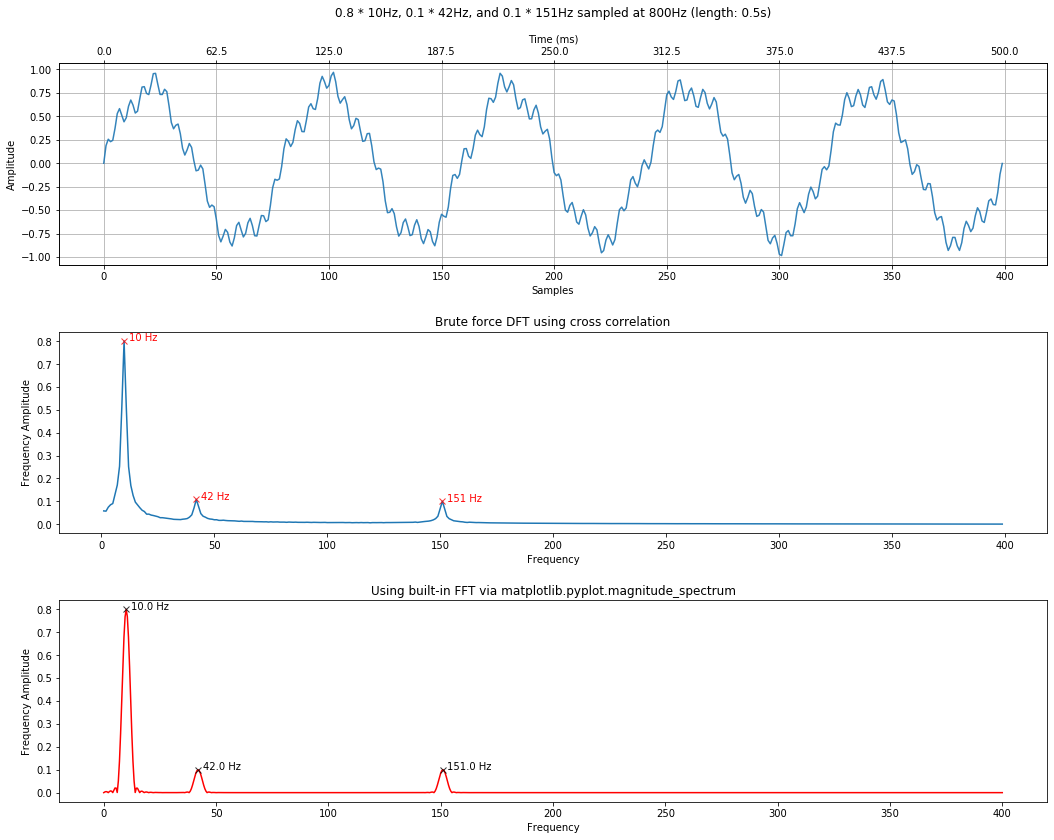

In [17]:
signal_composite = 0.8 * signal1 + 0.1 * signal2 + 0.1 * signal3
time_domain_title = f"0.8 * {freq1}Hz, 0.1 * {freq2}Hz, and 0.1 * {freq3}Hz sampled at 800Hz (length: {total_time_in_secs}s)"
calc_and_plot_xcorr_dft_with_ground_truth(signal_composite, sampling_rate, 
                                                time_domain_graph_title = time_domain_title);

Notice how the DFT peaks are proportional to the amplitudes.

Let's try another mix.

FloatProgress(value=1.0, max=400.0, min=1.0)

**Brute force cross-correlation DFT**
Num cross correlations: 399
Frequency step resolution for cross correlation: 1
Found 3 freq peak(s) at: 10, 42, 151 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 10 Hz (0.20), 42 Hz (0.20), 151 Hz (0.60) Hz

**Ground truth FFT**
Num FFT freq bins: 801
FFT Freq bin spacing: 0.5
Found 3 freq peak(s) at: 10.0, 42.0, 151.0 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 10.0 Hz (0.20), 42.0 Hz (0.20), 151.0 Hz (0.60) Hz


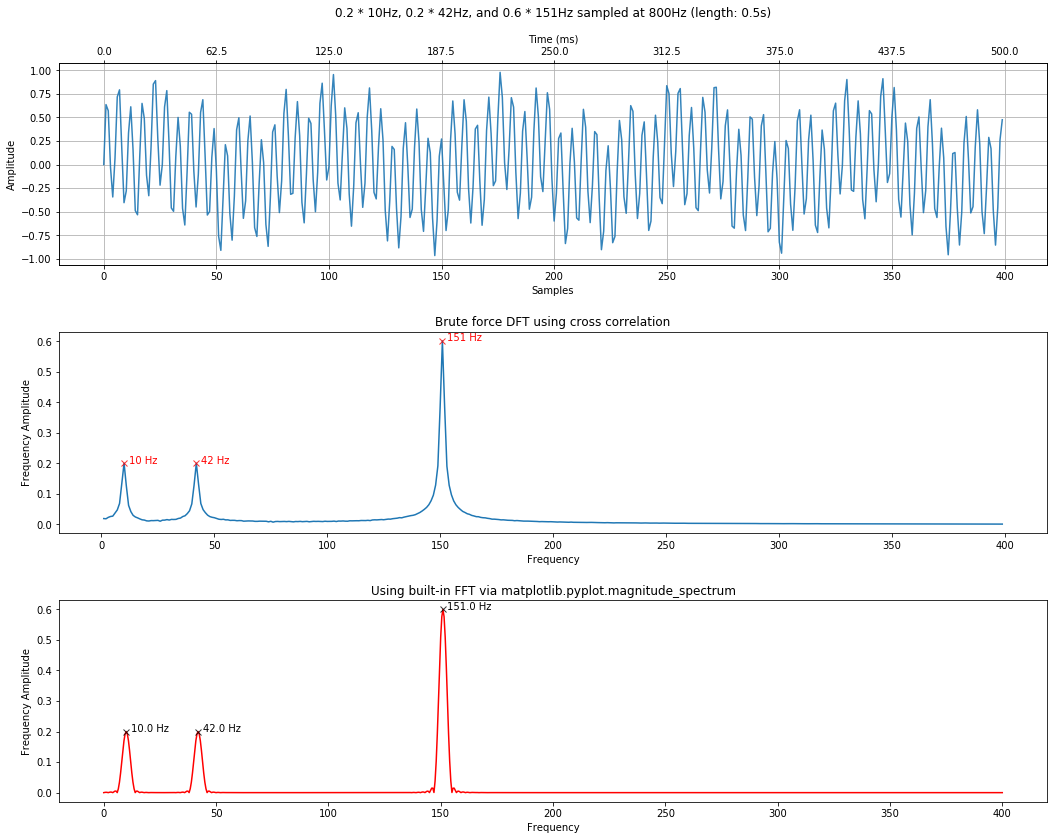

In [18]:
signal_composite = 0.2 * signal1 + 0.2 * signal2 + 0.6 * signal3
time_domain_title = f"0.2 * {freq1}Hz, 0.2 * {freq2}Hz, and 0.6 * {freq3}Hz sampled at 800Hz (length: {total_time_in_secs}s)"
calc_and_plot_xcorr_dft_with_ground_truth(signal_composite, sampling_rate, 
                                                time_domain_graph_title = time_domain_title);

FloatProgress(value=1.0, max=400.0, min=1.0)

**Brute force cross-correlation DFT**
Num cross correlations: 399
Frequency step resolution for cross correlation: 1
Found 5 freq peak(s) at: 10, 42, 151, 222, 347 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 10 Hz (0.50), 42 Hz (0.30), 151 Hz (0.20), 222 Hz (1.00), 347 Hz (0.80) Hz

**Ground truth FFT**
Num FFT freq bins: 801
FFT Freq bin spacing: 0.5
Found 5 freq peak(s) at: 10.0, 42.0, 151.0, 222.0, 347.0 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 10.0 Hz (0.50), 42.0 Hz (0.30), 151.0 Hz (0.20), 222.0 Hz (1.00), 347.0 Hz (0.80) Hz


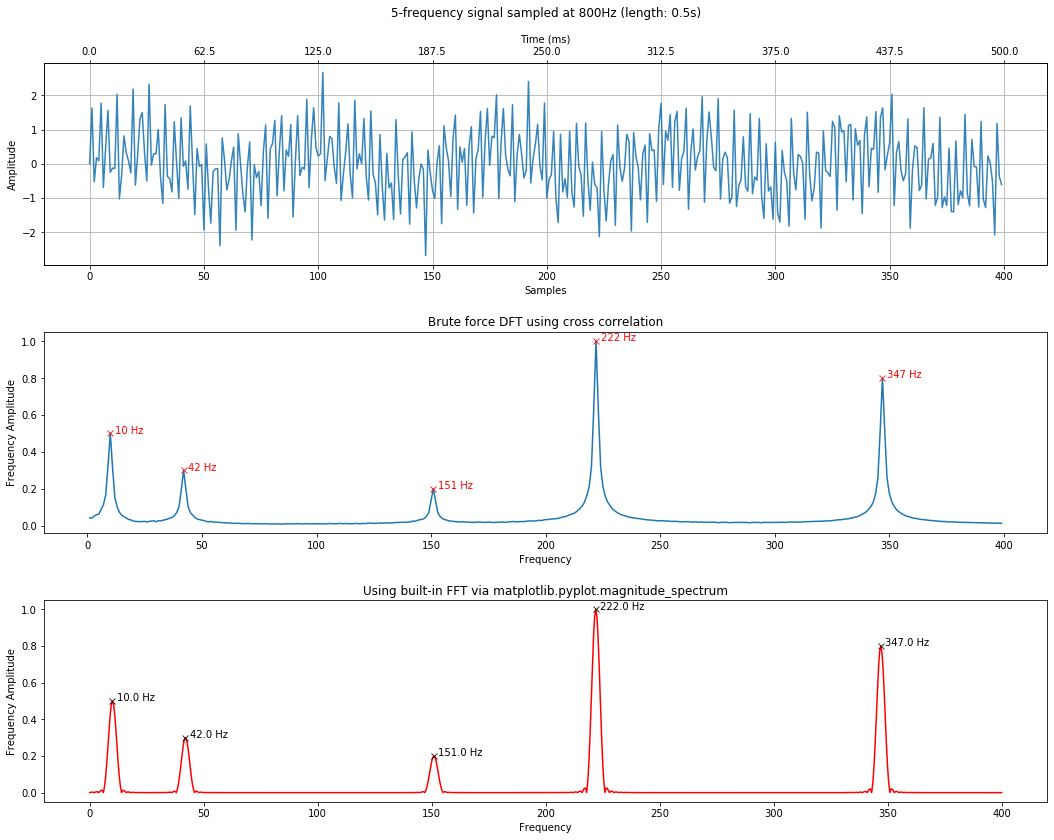

In [19]:
freq4 = 222
freq5 = 347

signal4 = makelab.signal.create_sine_wave(freq4, sampling_rate, total_time_in_secs)
signal5 = makelab.signal.create_sine_wave(freq5, sampling_rate, total_time_in_secs)

signal_composite = 0.5 * signal1 + 0.3 * signal2 + 0.2 * signal3 + 1 * signal4 + 0.8 * signal5
time_domain_title = f"5-frequency signal sampled at 800Hz (length: {total_time_in_secs}s)"
calc_and_plot_xcorr_dft_with_ground_truth(signal_composite, sampling_rate, 
                                                time_domain_graph_title = time_domain_title);

### Changing frequency precision

For the DFT by cross correlation, we can control the precision with which we detect frequencies in our signal by modifying the `step_size` of which frequencies we iterate over in our cross-correlation.

For example, let's attempt to detect a frequency at 49.5Hz. Remember that, by default, we step through integer frequencies from 1 to the Nyquist limit.

FloatProgress(value=1.0, max=400.0, min=1.0)

**Brute force cross-correlation DFT**
Num cross correlations: 399
Frequency step resolution for cross correlation: 1
Found 1 freq peak(s) at: 50 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 50 Hz (0.90) Hz

**Ground truth FFT**
Num FFT freq bins: 801
FFT Freq bin spacing: 0.5
Found 1 freq peak(s) at: 49.5 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 49.5 Hz (1.00) Hz


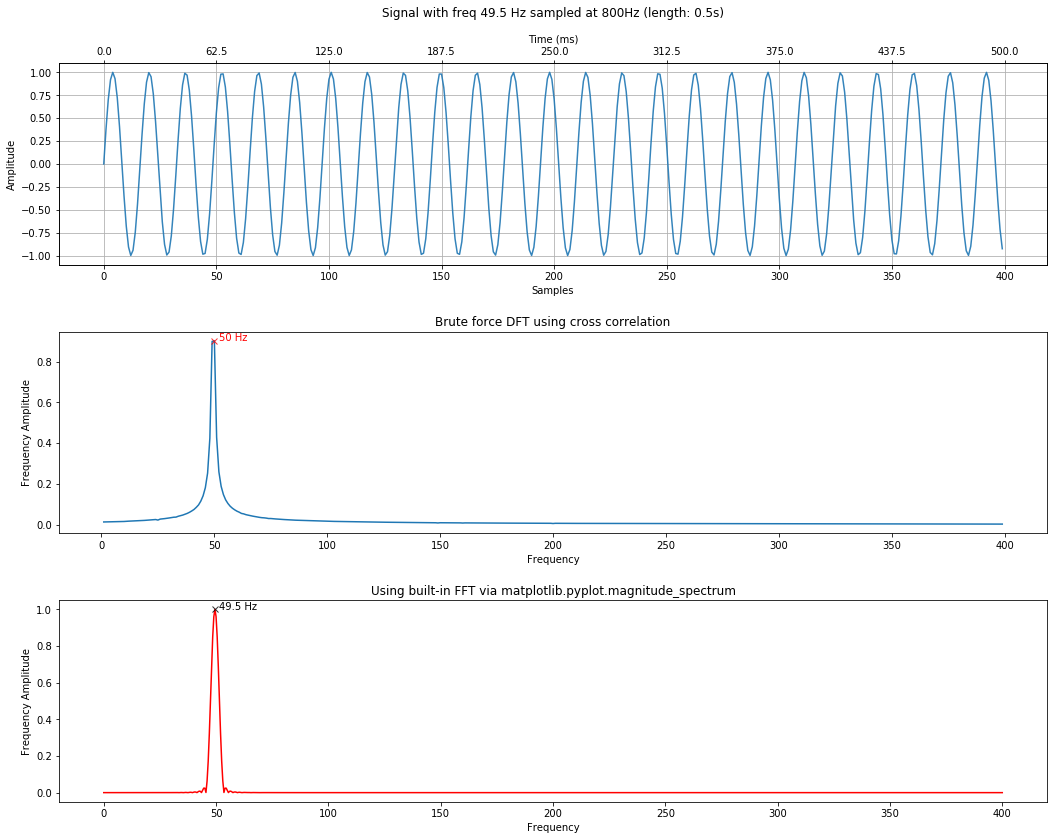

In [20]:
sampling_rate = 800
total_time_in_secs = 0.5
freq = 49.5 # feel free to change this to see what happens
signal = makelab.signal.create_sine_wave(freq, sampling_rate, total_time_in_secs)

time_domain_title = f"Signal with freq {freq} Hz sampled at 800Hz (length: {total_time_in_secs}s)"
calc_and_plot_xcorr_dft_with_ground_truth(signal, sampling_rate, 
                                          time_domain_graph_title = time_domain_title);


Notice how we were unable to precisely detect this frequency. However, if we set the `step_size` to 0.1, we will be able to (though it will slow down performance by an order of magnitude).

FloatProgress(value=1.0, max=400.0, min=1.0)

**Brute force cross-correlation DFT**
Num cross correlations: 3990
Frequency step resolution for cross correlation: 0.1
Found 1 freq peak(s) at: 49.50000000000004 Hz
The minimum peak amplitude threshold set to: 0.4
Freq and amplitudes: 49.50000000000004 Hz (1.00) Hz

**Ground truth FFT**
Num FFT freq bins: 801
FFT Freq bin spacing: 0.5
Found 1 freq peak(s) at: 49.5 Hz
The minimum peak amplitude threshold set to: 0.4
Freq and amplitudes: 49.5 Hz (1.00) Hz


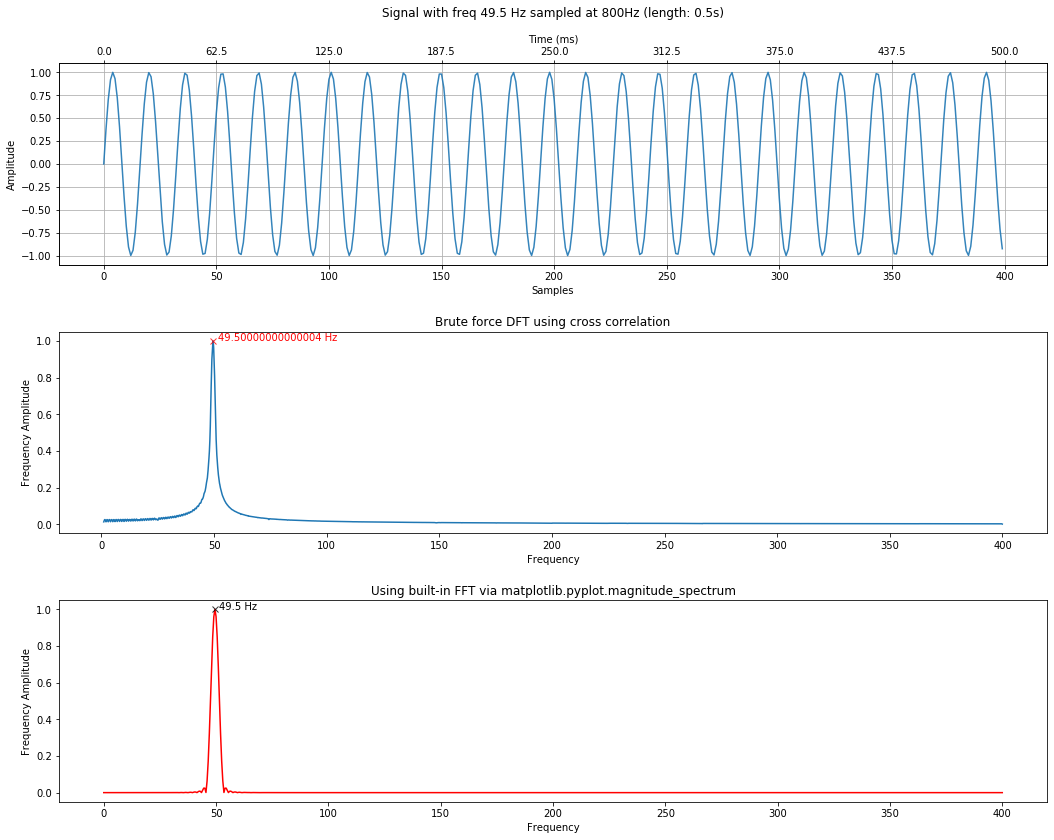

In [21]:
sampling_rate = 800
total_time_in_secs = 0.5
freq = 49.5 # feel free to change this to see what happens
signal = makelab.signal.create_sine_wave(freq, sampling_rate, total_time_in_secs)

xcorr_freq_step_size = 0.1
time_domain_title = f"Signal with freq {freq} Hz sampled at 800Hz (length: {total_time_in_secs}s)"
calc_and_plot_xcorr_dft_with_ground_truth(signal, sampling_rate, 
                                          time_domain_graph_title = time_domain_title,
                                         xcorr_freq_step_size=xcorr_freq_step_size,
                                         minimum_freq_amplitude = 0.4);


We could also increase our step size to a far more coarse-grained level, which will increase speed at a cost of precision.

Here, we're setting the step size to 10, which will result in a 100x speed up over 0.1.

FloatProgress(value=1.0, max=400.0, min=1.0)

**Brute force cross-correlation DFT**
Num cross correlations: 40
Frequency step resolution for cross correlation: 10
Found 1 freq peak(s) at: 51 Hz
The minimum peak amplitude threshold set to: 0.4
Freq and amplitudes: 51 Hz (0.43) Hz

**Ground truth FFT**
Num FFT freq bins: 801
FFT Freq bin spacing: 0.5
Found 1 freq peak(s) at: 49.5 Hz
The minimum peak amplitude threshold set to: 0.4
Freq and amplitudes: 49.5 Hz (1.00) Hz


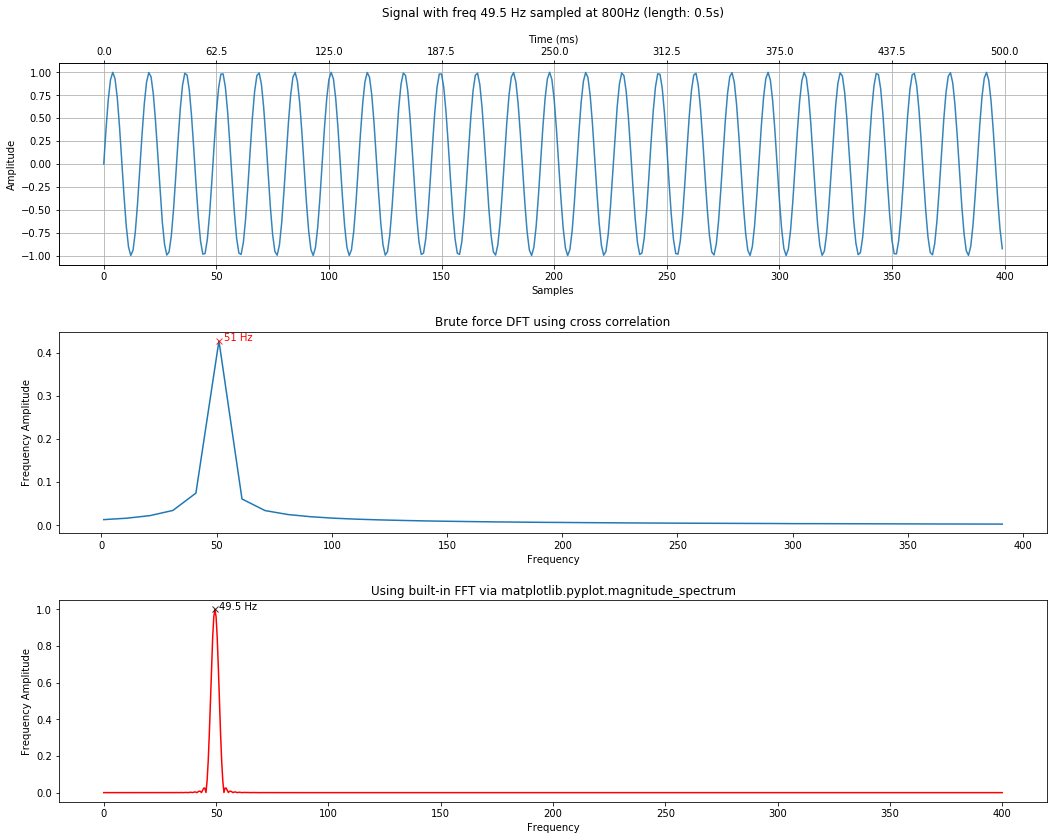

In [22]:
sampling_rate = 800
total_time_in_secs = 0.5
freq = 49.5 # feel free to change this to see what happens
signal = makelab.signal.create_sine_wave(freq, sampling_rate, total_time_in_secs)

xcorr_freq_step_size = 10
time_domain_title = f"Signal with freq {freq} Hz sampled at 800Hz (length: {total_time_in_secs}s)"
calc_and_plot_xcorr_dft_with_ground_truth(signal, sampling_rate, 
                                          time_domain_graph_title = time_domain_title,
                                         xcorr_freq_step_size=xcorr_freq_step_size,
                                         minimum_freq_amplitude = 0.4);

Importantly, in order to incrase the precision of an FFT, you have two options: either you increase the sampling rate (often not possible) or you incrase the number of samples provided to the FFT (in other words, provide a longer sample).

### To increase FFT amplitude estimation

Frequencies in the DFT are spaced at intervals of $\frac{f_s}{N}$ where $f_s$ is the sampling rate and $N$ is the length of the signal (*i.e.,* `len(signal)`). As the [Mathworks Matlab DFT](https://www.mathworks.com/help/signal/ug/amplitude-estimation-and-zero-padding.html) documentation states, "Attempting to estimate the amplitude of a sinusoid with a frequency that does not correspond to a DFT bin can result in an inaccurate estimate. Zero padding the data before computing the DFT often helps to improve the accuracy of amplitude estimates."

Importantly, while you can use **zero padding** to obtain more **accurate amplitude estimates** of the underlying frequency components in your signal, zero padding does **not** improve the **spectral (frequency) resolution** of the DFT. This resolution is, instead, determined by the number of samples and the sampling rate.

By default, the `calc_and_plot_xcorr_dft_with_ground_truth` method has been padding the FFT by 4 * len(s) to increase amplitude estimation precision. Let's see what happens when we pad and do not pad the signal. Note: we are only experimenting with the FFT here, not the DFT by correlation.

FloatProgress(value=1.0, max=400.0, min=1.0)

**Brute force cross-correlation DFT**
Num cross correlations: 798
Frequency step resolution for cross correlation: 0.5
Found 2 freq peak(s) at: 43.0, 202.5 Hz
The minimum peak amplitude threshold set to: 0.4
Freq and amplitudes: 43.0 Hz (1.00), 202.5 Hz (1.00) Hz

**Ground truth FFT**
Num FFT freq bins: 201
FFT Freq bin spacing: 2.0
Found 2 freq peak(s) at: 44.0, 202.0 Hz
The minimum peak amplitude threshold set to: 0.4
Freq and amplitudes: 44.0 Hz (0.85), 202.0 Hz (0.96) Hz


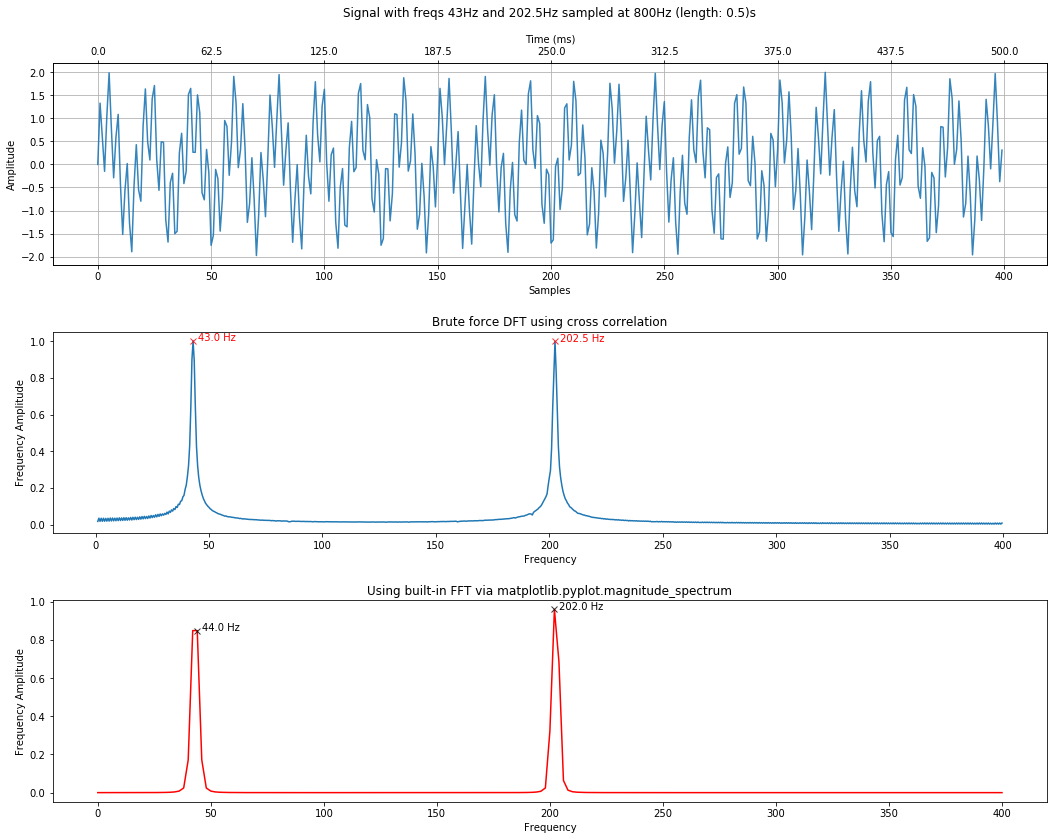

In [23]:
# Padding is set to zero 
sampling_rate = 800
total_time_in_secs = 0.5

freq1 = 43
freq2 = 202.5

signal1 = makelab.signal.create_sine_wave(freq1, sampling_rate, total_time_in_secs)
signal2 = makelab.signal.create_sine_wave(freq2, sampling_rate, total_time_in_secs)

signal_composite = signal1 + signal2
time_domain_title = f"Signal with freqs {freq1}Hz and {freq2}Hz sampled at 800Hz (length: {total_time_in_secs})s"
calc_and_plot_xcorr_dft_with_ground_truth(signal_composite, sampling_rate,
                                                time_domain_graph_title = time_domain_title,
                                                xcorr_freq_step_size = 0.5,
                                                minimum_freq_amplitude = 0.4, fft_pad_to=0);

FloatProgress(value=1.0, max=400.0, min=1.0)

**Brute force cross-correlation DFT**
Num cross correlations: 798
Frequency step resolution for cross correlation: 0.5
Found 2 freq peak(s) at: 43.0, 202.5 Hz
The minimum peak amplitude threshold set to: 0.4
Freq and amplitudes: 43.0 Hz (1.00), 202.5 Hz (1.00) Hz

**Ground truth FFT**
Num FFT freq bins: 401
FFT Freq bin spacing: 1.0
Found 2 freq peak(s) at: 43.0, 202.0 Hz
The minimum peak amplitude threshold set to: 0.4
Freq and amplitudes: 43.0 Hz (1.00), 202.0 Hz (0.96) Hz


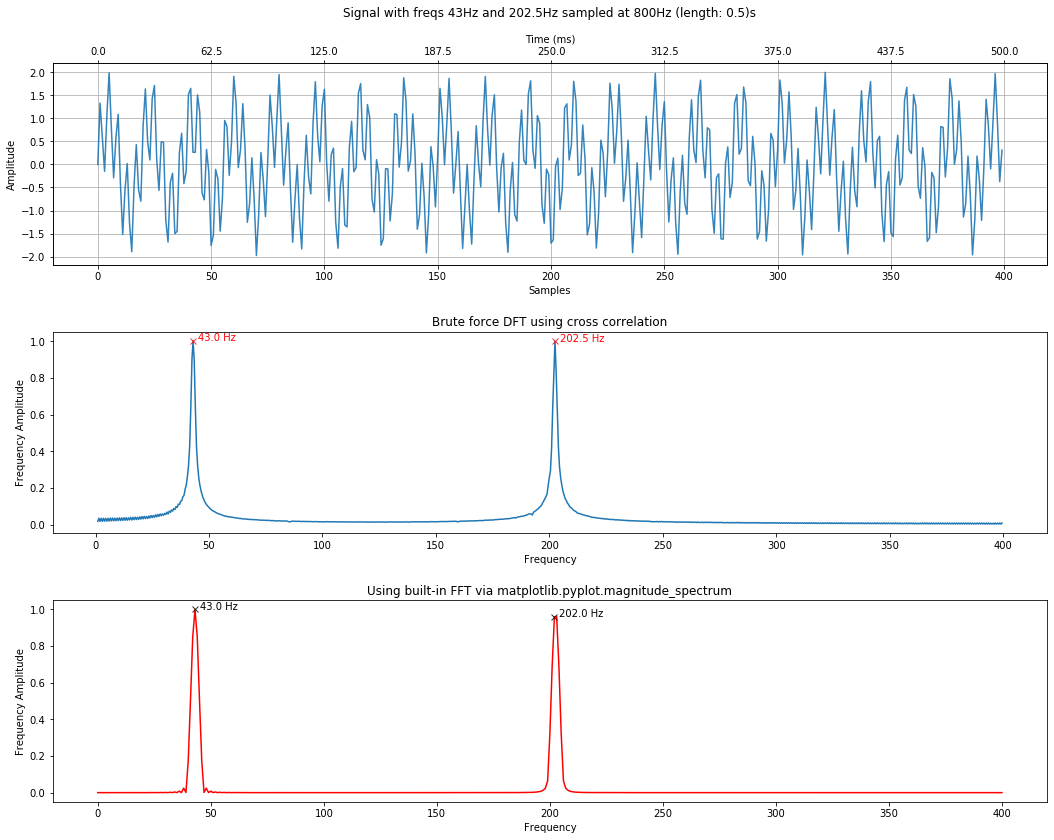

In [24]:
# Padding set to 2 * len(s)
calc_and_plot_xcorr_dft_with_ground_truth(signal_composite, sampling_rate,
                                                time_domain_graph_title = time_domain_title,
                                                xcorr_freq_step_size = 0.5,
                                                minimum_freq_amplitude = 0.4, fft_pad_to=2 * len(signal_composite));

FloatProgress(value=1.0, max=400.0, min=1.0)

**Brute force cross-correlation DFT**
Num cross correlations: 798
Frequency step resolution for cross correlation: 0.5
Found 2 freq peak(s) at: 43.0, 202.5 Hz
The minimum peak amplitude threshold set to: 0.4
Freq and amplitudes: 43.0 Hz (1.00), 202.5 Hz (1.00) Hz

**Ground truth FFT**
Num FFT freq bins: 801
FFT Freq bin spacing: 0.5
Found 2 freq peak(s) at: 43.0, 202.5 Hz
The minimum peak amplitude threshold set to: 0.4
Freq and amplitudes: 43.0 Hz (1.00), 202.5 Hz (1.00) Hz


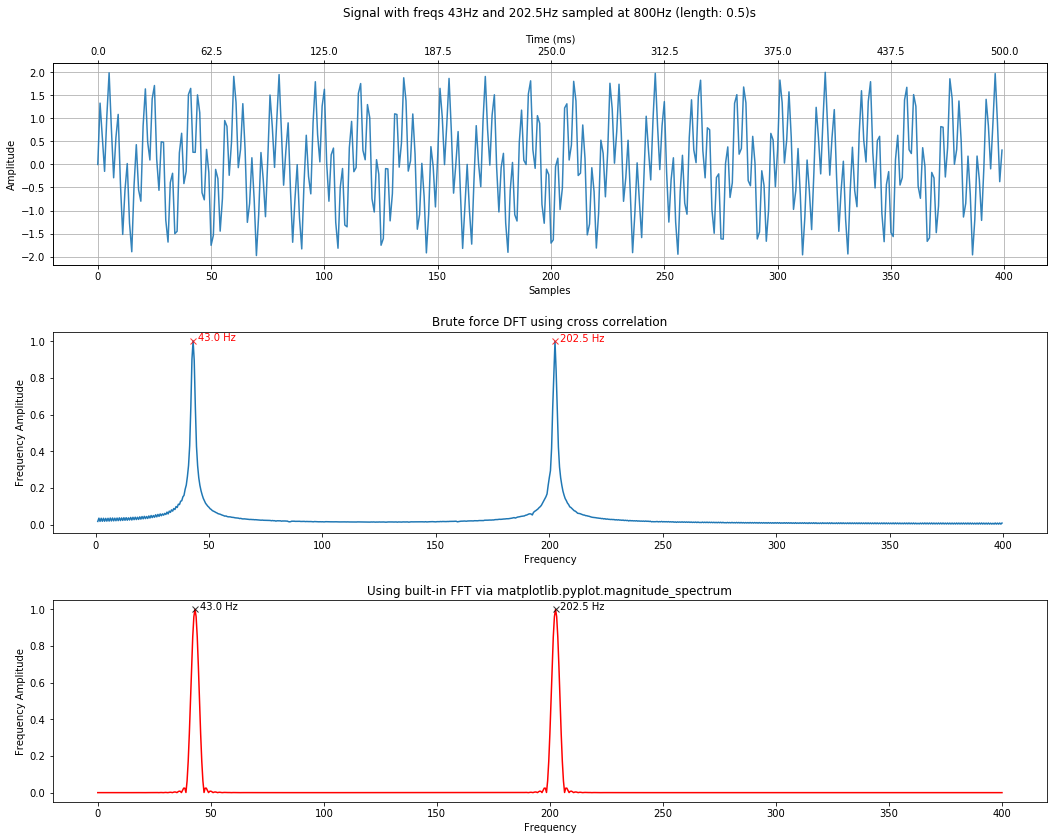

In [25]:
# Using default padding (4 * len(s))
calc_and_plot_xcorr_dft_with_ground_truth(signal_composite, sampling_rate,
                                                time_domain_graph_title = time_domain_title,
                                                xcorr_freq_step_size = 0.5,
                                                minimum_freq_amplitude = 0.4);

### Play with your own frequency mix

FloatProgress(value=1.0, max=400.0, min=1.0)

**Brute force cross-correlation DFT**
Num cross correlations: 399
Frequency step resolution for cross correlation: 1
Found 5 freq peak(s) at: 15, 80, 147, 224, 320 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 15 Hz (0.30), 80 Hz (1.50), 147 Hz (1.31), 224 Hz (0.45), 320 Hz (0.70) Hz

**Ground truth FFT**
Num FFT freq bins: 801
FFT Freq bin spacing: 0.5
Found 5 freq peak(s) at: 15.0, 80.0, 147.0, 223.5, 320.0 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 15.0 Hz (0.30), 80.0 Hz (1.50), 147.0 Hz (1.30), 223.5 Hz (0.50), 320.0 Hz (0.70) Hz

**TOP 3 FREQUENCIES: THE FREQ AND AMPLITUDES SHOULD MATCH THE SIGNAL**
Top 3 frequencies DFT by correlation (freq, amplitude coef):
[(80, 1.503017288946324), (147, 1.3052077804471574), (320, 0.7029319709663356)]
Top 3 frequencies by FFT (freq, amplitude coef):
[(80.0, 1.4999966857920404), (147.0, 1.2999956098759677), (320.0, 0.6999990853091388)]


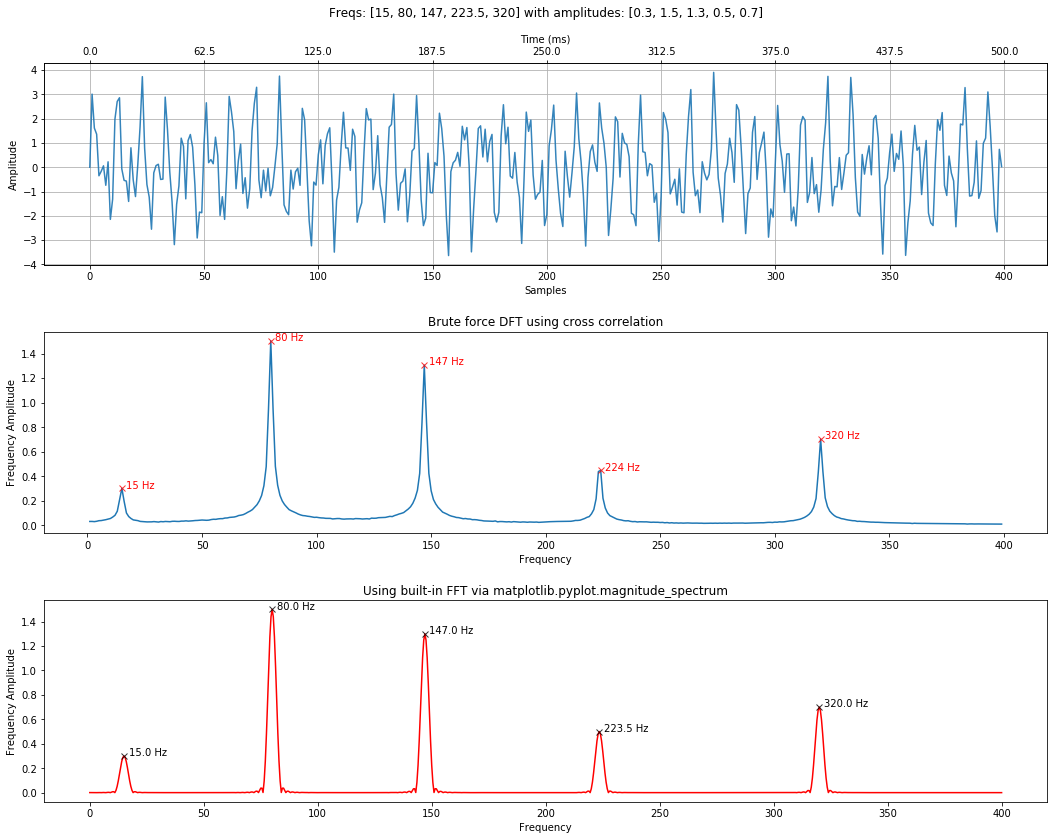

In [26]:
sampling_rate = 800
total_time_in_secs = 0.5
freqs = [15, 80, 147, 223.5, 320] # add or change frequencies here
amplitudes = [0.3, 1.5, 1.3, 0.5, 0.7]

# Or uncomment this out for random amplitudes
# amplitudes = np.random.uniform(low = 0.1, high = 1, size=(len(freqs)))

signals = []
signal_composite = makelab.signal.create_sine_wave(0, sampling_rate, total_time_in_secs)
for i, freq in enumerate(freqs):
    # set random amplitude for each freq (you can change this, of course)
    signal = amplitudes[i] * makelab.signal.create_sine_wave(freq, sampling_rate, total_time_in_secs)
    signals.append(signal)
    signal_composite += signal

#signal_composite = signal_composite / len(signals)
time_domain_title = f"Freqs: {freqs} with amplitudes: {amplitudes}"
result = calc_and_plot_xcorr_dft_with_ground_truth(signal_composite, sampling_rate, 
                                                time_domain_graph_title = time_domain_title)

(fig, axes, xcorr_freqs, xcorr_results, fft_freqs, fft_spectrum) = result

# Print out top 3 frequencies
print()
print("**TOP 3 FREQUENCIES: THE FREQ AND AMPLITUDES SHOULD MATCH THE SIGNAL**")
top_n = 3
top_freq_peaks_xcorr = get_top_n_frequency_peaks(top_n, xcorr_freqs, xcorr_results)
print(f"Top {top_n} frequencies DFT by correlation (freq, amplitude coef):\n{top_freq_peaks_xcorr}") 
    
top_freq_peaks_fft = get_top_n_frequency_peaks(top_n, fft_freqs, fft_spectrum)
print(f"Top {top_n} frequencies by FFT (freq, amplitude coef):\n{top_freq_peaks_fft}")


In [48]:
f = get_top_n_frequency_peaks(top_n, xcorr_freqs, xcorr_results, min_amplitude_threshold = None)
print(f)

[(80, 1.503017288946324), (147, 1.3052077804471574), (320, 0.7029319709663356)]


In [49]:
top_n = 3
top_n_frequencies_with_amplitudes = get_top_n_frequencies(top_n, xcorr_freqs, 
                                                                   xcorr_results, min_amplitude_threshold = 0)
print(top_n_frequencies_with_amplitudes)

[(80, 1.503017288946324), (147, 1.3052077804471574), (79, 0.9455015053771382)]


### Analyzing some sound wave files

Let's analyze a few sound wave files, both to demonstrate frequency analysis of more complicated signals and to show how slow our DFT by correlation approach is compared to an FFT. 

#### Analyzing a 5-frequency chord
Let's analyze the same five-frequency chord from our [Quantization and Sampling lesson](https://makeabilitylab.github.io/physcomp/signals/QuantizationAndSampling/index.html#Playing-a-chord-with-frequencies-from-261Hz-to-4186Hz). A one-second sample with a 11,025Hz sampling rate containing the following frequencies:
- $C4$ (Middle C) at 261.6256 Hz
- $D4$ 293.665 Hz
- $G4$ 391.995 Hz
- $C7$ (Double High C) at 2093 Hz
- $C8$ (Eighth Octave) at 4186.01 Hz


Plot the signal

Sampling rate: 11025 Hz
Number of channels = 1
Total samples: 11025
Total time: 1.0 secs


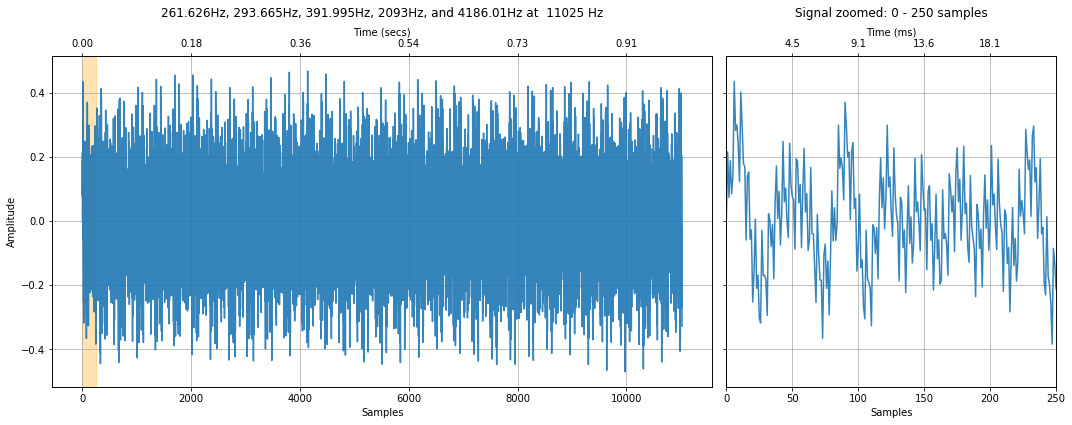

In [30]:
# Equation used to produce the audio file in Goldwave
# 0.2 * sin(2*pi*261.626*t) + 0.2 *  sin(2*pi*293.665*t) + 0.2 * sin(2*pi*391.995*t) + 0.2 *  sin(2*pi*2093*t) + 0.2 * sin(2*pi*4186.01*t)
sinewavechord_soundfile = 'data/audio/SineWaveChord_MinFreq261_MaxFreq4186_1sec_11025Hz_mono.wav'
sampling_rate, sine_wave_chord_11025 = sp.io.wavfile.read(sinewavechord_soundfile)
#sampling_rate, audio_data_44100 = sp.io.wavfile.read('data/audio/greenday.wav')

print(f"Sampling rate: {sampling_rate} Hz")
print(f"Number of channels = {len(sine_wave_chord_11025.shape)}")
print(f"Total samples: {sine_wave_chord_11025.shape[0]}")
print(f"Total time: {sine_wave_chord_11025.shape[0] / sampling_rate} secs")

sine_wave_chord_11025 = sine_wave_chord_11025 / 2**16 # normalize to -1 to 1
quantization_bits = 16
xlim_zoom = (0, 250)
title = f"261.626Hz, 293.665Hz, 391.995Hz, 2093Hz, and 4186.01Hz at  {sampling_rate} Hz" 
makelab.signal.plot_signal(sine_wave_chord_11025, sampling_rate, xlim_zoom = xlim_zoom, title = title)

ipd.Audio(sine_wave_chord_11025, rate=sampling_rate)

Perform the frequency analysis. Remember, this will be slow due to the cross-correlation DFT. On my Windows laptop, it look 1min, 36 secs to complete.

FloatProgress(value=1.0, max=5512.0, min=1.0)

**Brute force cross-correlation DFT**
Num cross correlations: 5511
Frequency step resolution for cross correlation: 1
Found 5 freq peak(s) at: 262, 294, 392, 2093, 4186 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 262 Hz (0.10), 294 Hz (0.10), 392 Hz (0.10), 2093 Hz (0.10), 4186 Hz (0.10) Hz

**Ground truth FFT**
Num FFT freq bins: 22051
FFT Freq bin spacing: 0.25
Found 5 freq peak(s) at: 261.75, 293.75, 392.0, 2093.0, 4186.0 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 261.75 Hz (0.10), 293.75 Hz (0.10), 392.0 Hz (0.10), 2093.0 Hz (0.10), 4186.0 Hz (0.10) Hz
Wall time: 2min 5s


(<Figure size 1080x864 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028560F5EB38>,
       dtype=object),
 array([   1,    2,    3, ..., 5509, 5510, 5511]),
 array([0.00065665, 0.00065907, 0.000659  , ..., 0.00017535, 0.00017313,
        0.0001728 ]),
 array([0.00000e+00, 2.50000e-01, 5.00000e-01, ..., 5.51200e+03,
        5.51225e+03, 5.51250e+03]),
 array([1.33233366e-07, 1.31401614e-07, 1.26463761e-07, ...,
        8.06943423e-08, 9.22278731e-08, 9.62957467e-08]))

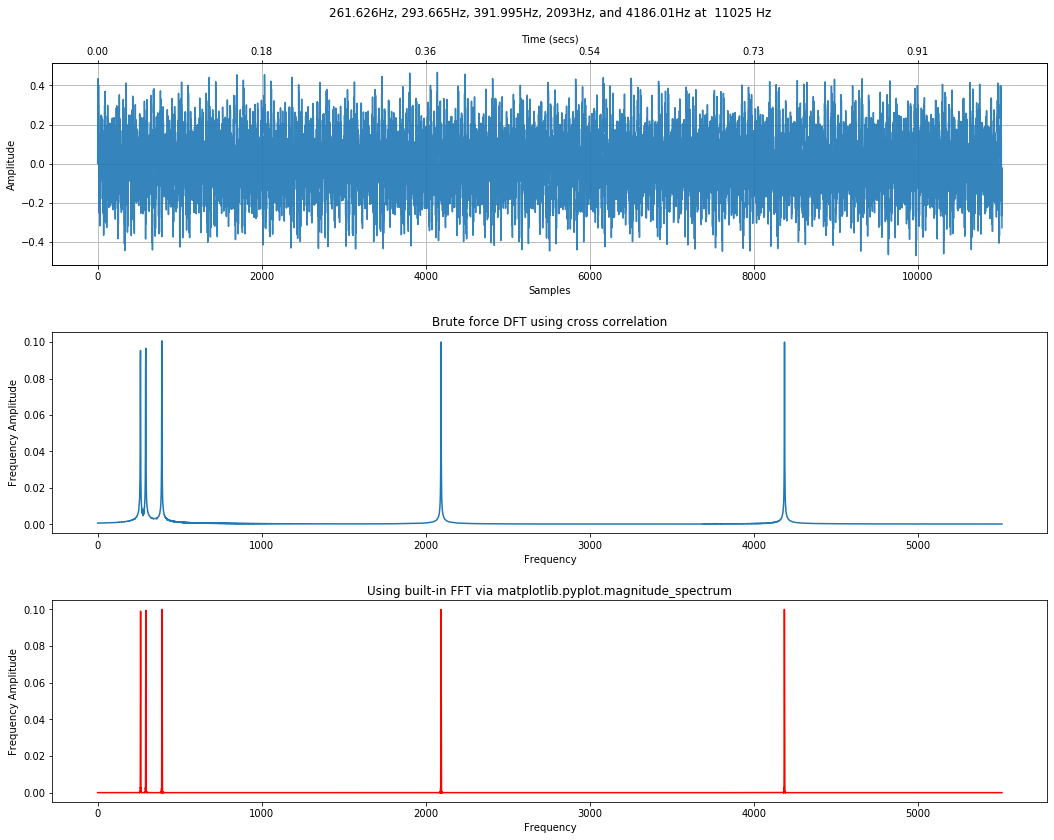

In [31]:
%%time
calc_and_plot_xcorr_dft_with_ground_truth(sine_wave_chord_11025, sampling_rate, 
                                                time_domain_graph_title = title,
                                                include_annotations = False);

How long does **just** the FFT take? Orders of magnitude shorter. Around 130ms (and this includes plotting time as well).

Wall time: 133 ms


(<Figure size 1080x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000285612475C0>,
       dtype=object))

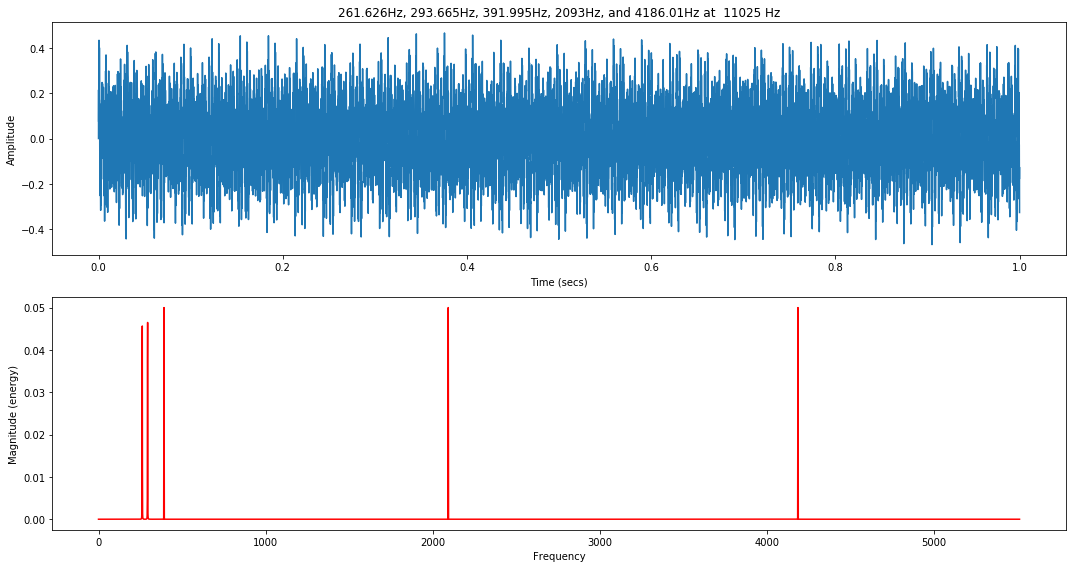

In [32]:
%%time
t = np.arange(len(sine_wave_chord_11025)) / sampling_rate
makelab.signal.plot_signal_and_magnitude_spectrum(t, sine_wave_chord_11025, sampling_rate, title = title);

### Analyzing the human voice
Let's analyze the same "Hello" sound file example that we played with in [Quantization and Sampling](https://makeabilitylab.github.io/physcomp/signals/QuantizationAndSampling/index.html#Example:-how-does-quantization-affect-audio-signals?). 

We are going to load a downsampled (8,000 Hz) version because the human voice resonates at lower frequencies (we don't need a super high sampling rate).

Sampling rate: 8000 Hz
Number of channels = 1
Total samples: 5594
Total time: 0.69925 secs


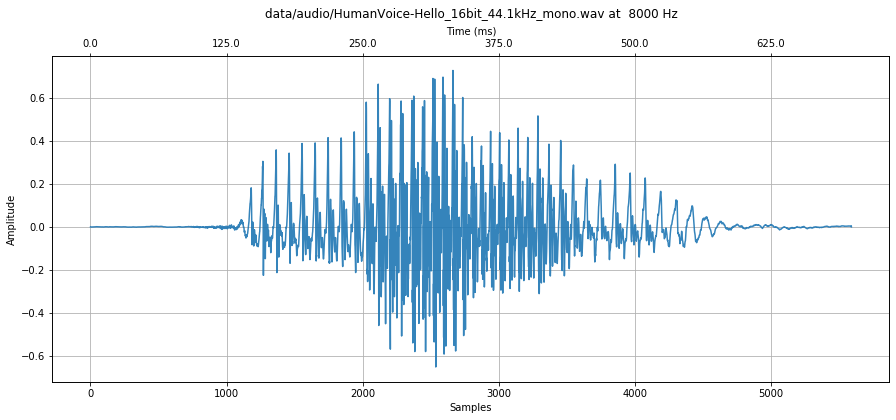

In [33]:
soundfile = 'data/audio/HumanVoice-Hello_16bit_44.1kHz_mono.wav'
audio_data, sampling_rate = librosa.load(soundfile, sr=8000)

print(f"Sampling rate: {sampling_rate} Hz")
print(f"Number of channels = {len(audio_data.shape)}")
print(f"Total samples: {audio_data.shape[0]}")
print(f"Total time: {audio_data.shape[0] / sampling_rate} secs")


title = f"{soundfile} at  {sampling_rate} Hz" 
makelab.signal.plot_signal(audio_data, sampling_rate, title = title)

ipd.Audio(audio_data, rate=sampling_rate)

FloatProgress(value=1.0, max=2000.0, min=1.0)

**Brute force cross-correlation DFT**
Num cross correlations: 1999
Frequency step resolution for cross correlation: 1
Found 0 freq peak(s) at:  Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes:  Hz

**Ground truth FFT**
Num FFT freq bins: 11189
FFT Freq bin spacing: 0.1787629603146228
Found 0 freq peak(s) at:  Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes:  Hz
Wall time: 5.98 s


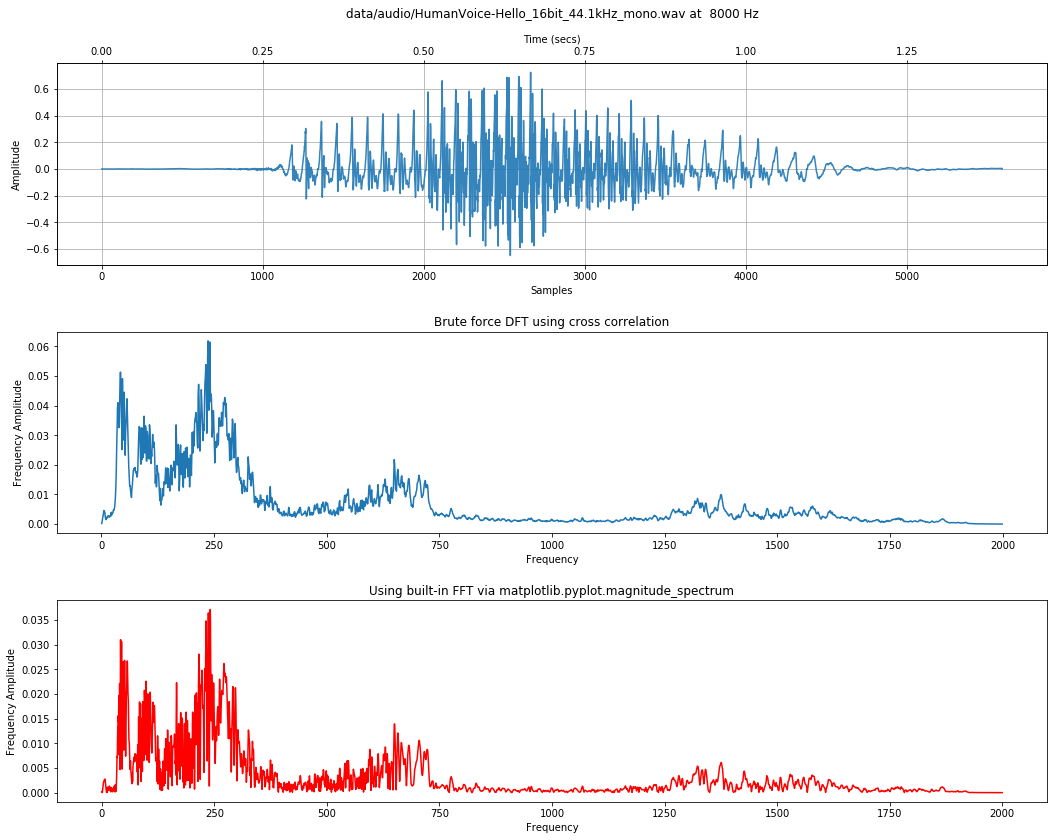

In [50]:
%%time
result = calc_and_plot_xcorr_dft_with_ground_truth(audio_data, sampling_rate, 
                                                time_domain_graph_title = title,
                                                include_annotations = False)

## Fast Fourier Transforms (FFT)

In the examples above, we were using matplotlib's [`magnitude_spectrum`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.magnitude_spectrum.html) method to calculate and plot the FFT.

As the [NumpPy DFT](https://numpy.org/doc/stable/reference/routines.fft.html) documentation highlights, "the DFT has become a mainstay of numerical computing in part because of a very fast algorithm for computing it, called the Fast Fourier Transform (FFT), which was known to Gauss (1805) but was brought to light in its current form by Cooley and Tukey in 1965." This Tukey, by the way, is John Tukey—the same Tukey who invented the [box plot](https://en.wikipedia.org/wiki/Box_plot) and a number of statistical approaches (like the [Tukey range test](https://en.wikipedia.org/wiki/Tukey%27s_range_test)).

The FFT reduces the computational complexity of the DFT from $O(N^2)$ to $O(N \log N)$ but is more complicated mathematically, so we will not attempt to describe it here; however, we will show you how to use it and what to watch out for. As Smith states in his [DSP book](http://www.dspguide.com/CH12.PDF), "while the FFT requires only a few dozen lines of code algorithms in DSP. But don't despair! You can easily use published FFT routines without fully understanding the internal workings."

For more information, see the FFT chapter in the DSP Guide ([Smith, Chapter 12](http://www.dspguide.com/CH12.PDF)) or the [Wikipedia article](https://en.wikipedia.org/wiki/Fast_Fourier_transform).

### NumPy's FFT

So, let's switch now to calculating the FFT using NumPy, which has, unsurprisingly a rich [DFT](https://numpy.org/doc/stable/reference/routines.fft.html) library—all implemented as FFTs.

If `a` is a time domain signal, calling `np.fft.fft(a)` will return a complex array: the *real part* will correspond to correlations to cosine waves at enumerated frequencies and the *imaginary part* will correspond to sine wave frequencies. We'll call this `fft_result`.

To obtain the amplitude spectrum, call `np.abs(fft_result)` or to obtain the power spectrum, call `np.abs(fft_result)**2`.

### Example FFT using a 10 Hz signal

Let's begin by generating and then analyzing a simple 10Hz sinusoidal signal sampled at 800Hz with length 500ms.

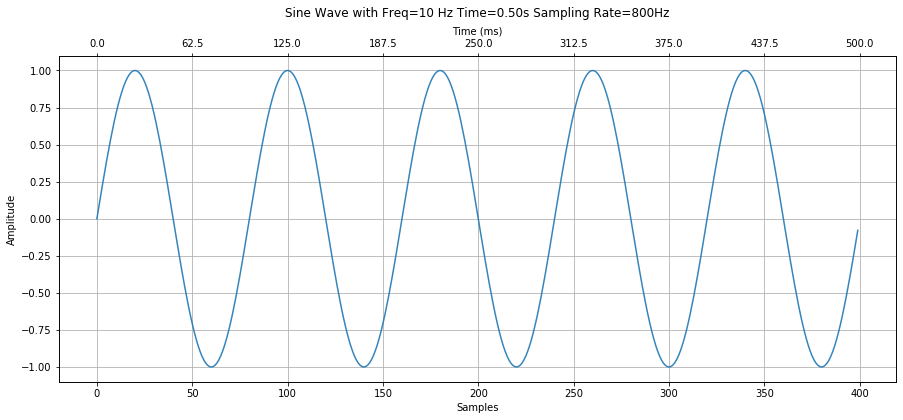

In [23]:
sampling_rate = 800
freq = 10 
total_time_in_secs = 0.5

s = makelab.signal.create_sine_wave(freq, sampling_rate, total_time_in_secs)

# Plot the signal
graph_title = f"Sine Wave with Freq={freq} Hz Time={total_time_in_secs:.2f}s Sampling Rate={sampling_rate}Hz"
makelab.signal.plot_signal(s, sampling_rate, title=graph_title);

#### Compute the FFT

Compute the FFT via [`np.fft.fft`](https://numpy.org/doc/1.18/reference/generated/numpy.fft.fft.html), which takes in:
- **a**: the time-series signal `a` (we use `s` below), 
- **n**: the length of `a` (defaults to `len(a)`) 
- **axis**: the axis to compute the FFT (we're using unidimensional NumPy arrays, so we don't need to supply anything here)
- **norm**: the normalization mode. By default, the FFT spectrum is scaled by $\frac{1}{n}$; however, setting this to 'ortho' will scale by $\frac{1}{\sqrt(n)}$

And returns a complex NumPy array consisting of the cosine and sine amplitudes.

It's OK if this is a little fuzzy. Let's dive in and explore. You'll learn by example (and, eventually, by using FFTs yourself in analyzing signals!).

In [24]:
# Compute the FFT
fft_result = np.fft.fft(s)

#### Calculate the frequency bins

Just as we could control the "step size" to check for particular frequencies in our DFT by correlation (*e.g.,* step by 1Hz, by 5Hz, etc.), the FFT also has a frequency resolution

In [25]:
num_freq_bins = len(fft_result)
print(f"Num freq bins: {num_freq_bins}")

# NumPy supplies a convenience function to get an array of frequencies
# corresponding to the num of freq bins that we have
# This is based on the length of the signal s and the sampling rate
fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
print(f"FFT freq bin spacing: {fft_freqs[1] - fft_freqs[0]}. This is the resolution of the FFT.")

# You could also do this, it's functionally equivalent to the above fftfreq call
# fft_freqs = np.fft.fftfreq(num_freq_bins) * sampling_rate

Num freq bins: 400
FFT freq bin spacing: 2.0. This is the resolution of the FFT.


#### Plot the raw FFT result

Plot real and imaginary parts of signal. The amplitudes of the cosine waves are contained in `fft_result.real` while the amplitudes of the sine waves are contained in `fft_result.imag`. 

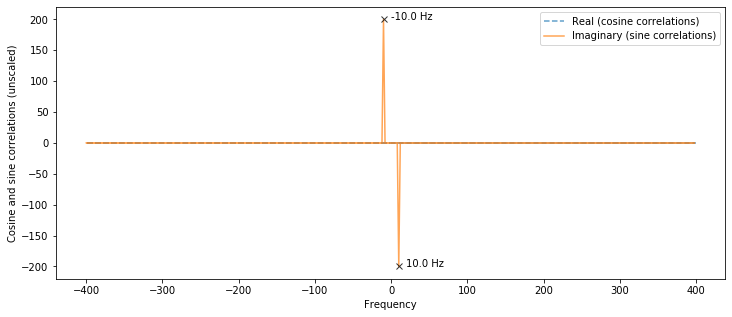

In [26]:
# The fft_result is composed of sine and cosine wave amplitudes
# We're only going to see amplitudes in fft_result.imag because we 
# generated a sine wave.
fft_sine_wave_amplitudes = fft_result.imag
fft_cos_wave_amplitudes = fft_result.real

# Plot these signals
plt.figure(figsize=(12,5))
plt.plot(fft_freqs, fft_cos_wave_amplitudes, label="Real (cosine correlations)", linestyle="--", alpha=0.7)
plt.plot(fft_freqs, fft_sine_wave_amplitudes, label="Imaginary (sine correlations)", alpha=0.7)
plt.ylabel("Cosine and sine correlations (unscaled)")
plt.xlabel("Frequency")
plt.legend()

# Annotate the peak and valley
peak_idx = np.argmax(fft_sine_wave_amplitudes) # get max val array index loc
valley_idx = np.argmin(fft_sine_wave_amplitudes) # get min val array index loc

plt.plot(fft_freqs[peak_idx], fft_sine_wave_amplitudes[peak_idx], 
             marker="x", color="black", alpha=0.8)
plt.text(fft_freqs[peak_idx] + 10, fft_sine_wave_amplitudes[peak_idx], 
         f"{fft_freqs[peak_idx]} Hz", color="black")

plt.plot(fft_freqs[valley_idx], fft_sine_wave_amplitudes[valley_idx], 
             marker="x", color="black", alpha=0.8)
plt.text(fft_freqs[valley_idx] + 10, fft_sine_wave_amplitudes[valley_idx], 
         f"{fft_freqs[valley_idx]} Hz", color="black")

plt.show()

#### Calculate and plot the amplitude spectrum

Just as we did with the DFT by correlation, we want to plot the amplitudes of the detected frequencies in our frequency plot. So, we'll take the `np.abs()` of our FFT result and then scale.

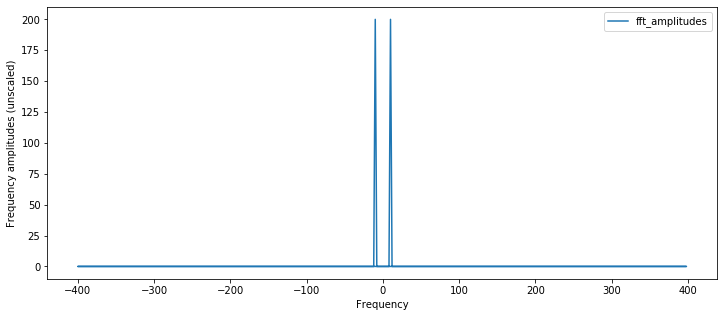

In [27]:
# Plot the amplitude spectrum

# As the NumPy documentation states, use np.abs(fft_result) to calculate the amplitude spectrum
# and np.abs(fft_result)**2 to calculate the power spectrum
# https://numpy.org/doc/stable/reference/routines.fft.html#implementation-details
fft_amplitudes = np.abs(fft_result)

plt.figure(figsize=(12,5))
plt.plot(fft_freqs, fft_amplitudes, label="fft_amplitudes")
plt.ylabel("Frequency amplitudes (unscaled)")
plt.xlabel("Frequency")
plt.legend()
plt.show()

#### Scale the amplitude spectrum

The two-sided amplitude spectrum shows half the peak amplitude at the positive and negative frequencies. To convert to a single-sided form, we'll multiply by two and discard the negative side of array. 

Note that here we will scale only by len(s) (rather than 2/len(s)) so that we are consistent with Section 5.2.

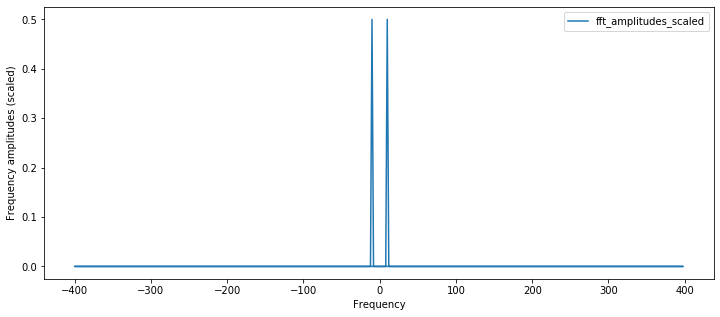

In [28]:
fft_amplitudes_scaled = np.abs(fft_result) / (len(s)) # scale by len(s)

plt.figure(figsize=(12,5))
plt.plot(fft_freqs, fft_amplitudes_scaled, label="fft_amplitudes_scaled")
plt.ylabel("Frequency amplitudes (scaled)")
plt.xlabel("Frequency")
plt.legend()
plt.show()

#### Slice results to positive frequencies

We only care about positive frequencies, so cut our result array in half.

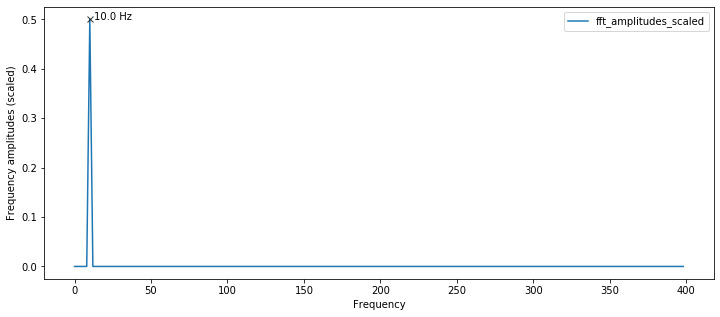

In [29]:
half_freq_bins = num_freq_bins // 2
positive_freqs = fft_freqs[:half_freq_bins]
fft_result_for_pos_freqs = fft_result[:half_freq_bins]

fft_amplitudes_for_pos_freqs = fft_amplitudes[:half_freq_bins]
fft_amplitudes_scaled_for_pos_freqs = fft_amplitudes_scaled[:half_freq_bins]

plt.figure(figsize=(12,5))
plt.plot(positive_freqs, fft_amplitudes_scaled_for_pos_freqs, label="fft_amplitudes_scaled")
plt.ylabel("Frequency amplitudes (scaled)")
plt.xlabel("Frequency")
plt.legend()

# Extract and print out stats about the frequency analysis
highest_mag_spectrum_idx = np.argmax(fft_amplitudes_scaled_for_pos_freqs)
highest_mag = fft_amplitudes_scaled_for_pos_freqs[highest_mag_spectrum_idx]
freq_at_highest_mag = positive_freqs[highest_mag_spectrum_idx]

plt.plot(freq_at_highest_mag, highest_mag, marker="x", color="black", alpha=0.8)
plt.text(freq_at_highest_mag + 3, highest_mag, f"{freq_at_highest_mag} Hz", color="black")
plt.show()

#### Compare the FFT result to our previous approaches

How does the NumPy FFT compare to our DFT by correlation and `matplotlib.magnitude_spectrum` approaches? 

It should look nearly the same. And it does!

FloatProgress(value=1.0, max=400.0, min=1.0)

**Brute force cross-correlation DFT**
Num cross correlations: 399
Frequency step resolution for cross correlation: 1
Found 1 freq peak(s) at: 10 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 10 Hz (1.00) Hz

**Ground truth FFT**
Num FFT freq bins: 801
FFT Freq bin spacing: 0.5
Found 1 freq peak(s) at: 10.0 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 10.0 Hz (1.00) Hz


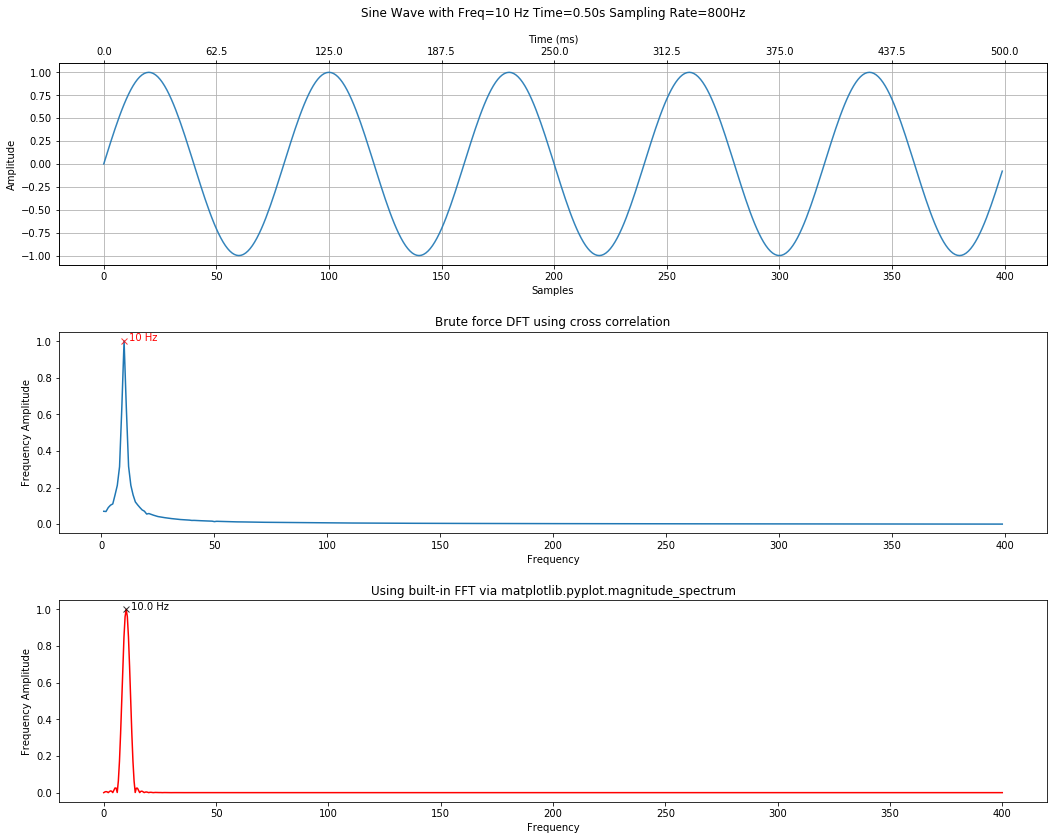

In [42]:
calc_and_plot_xcorr_dft_with_ground_truth(s, sampling_rate, 
                                          time_domain_graph_title = graph_title);

### Another example using 22 Hz signal

Let's try another signal but put all the steps together in one cell.

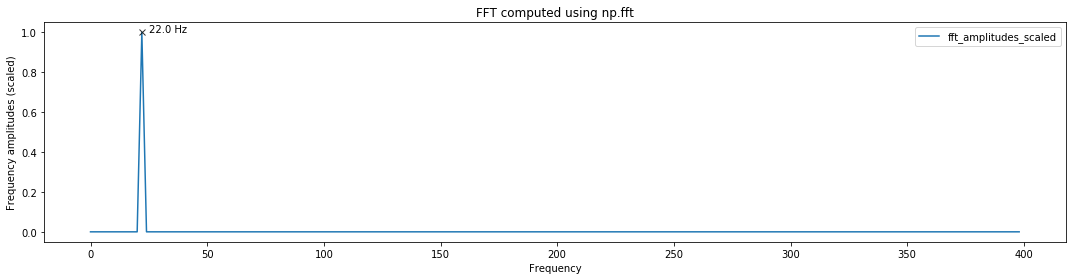

FloatProgress(value=1.0, max=400.0, min=1.0)

**Brute force cross-correlation DFT**
Num cross correlations: 399
Frequency step resolution for cross correlation: 1
Found 1 freq peak(s) at: 22 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 22 Hz (1.00) Hz

**Ground truth FFT**
Num FFT freq bins: 801
FFT Freq bin spacing: 0.5
Found 1 freq peak(s) at: 22.0 Hz
The minimum peak amplitude threshold set to: 0.08
Freq and amplitudes: 22.0 Hz (1.00) Hz


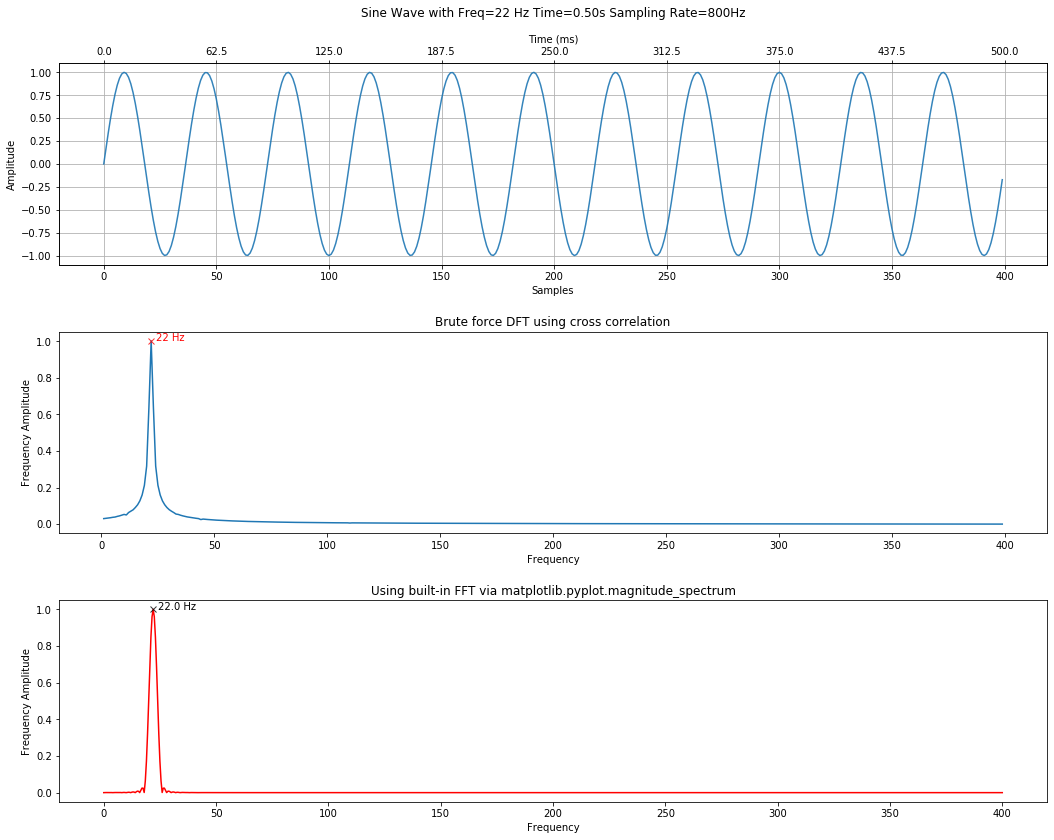

In [22]:
sampling_rate = 800
freq = 22 # feel free to change this
total_time_in_secs = 0.5

graph_title = f"Sine Wave with Freq={freq} Hz Time={total_time_in_secs:.2f}s Sampling Rate={sampling_rate}Hz"
s = makelab.signal.create_sine_wave(freq, sampling_rate, total_time_in_secs)

fft_result = np.fft.fft(s)
num_freq_bins = len(fft_result)
fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
half_freq_bins = num_freq_bins // 2

fft_freqs = fft_freqs[:half_freq_bins]
fft_result = fft_result[:half_freq_bins]
fft_amplitudes = np.abs(fft_result)
fft_amplitudes_scaled = 2 * fft_amplitudes / (len(s))

plt.figure(figsize=(15,4))
plt.plot(fft_freqs, fft_amplitudes_scaled, label="fft_amplitudes_scaled")
plt.ylabel("Frequency amplitudes (scaled)")
plt.xlabel("Frequency")
plt.title("FFT computed using np.fft")
plt.legend()
plt.tight_layout()

# Extract and print out stats about the frequency analysis
highest_mag_spectrum_idx = np.argmax(fft_amplitudes_scaled)
highest_mag = fft_amplitudes_scaled[highest_mag_spectrum_idx]
freq_at_highest_mag = fft_freqs[highest_mag_spectrum_idx]

plt.plot(freq_at_highest_mag, highest_mag, marker="x", color="black", alpha=0.8)
plt.text(freq_at_highest_mag + 3, highest_mag, f"{freq_at_highest_mag} Hz", color="black")
plt.show()

# Compare with our previous methods
calc_and_plot_xcorr_dft_with_ground_truth(s, sampling_rate, 
                                          time_domain_graph_title = graph_title);

### Analyzing a composite signal


Created composite signal with frequencies: [13, 25, 67, 88, 133, 188, 250, 333]


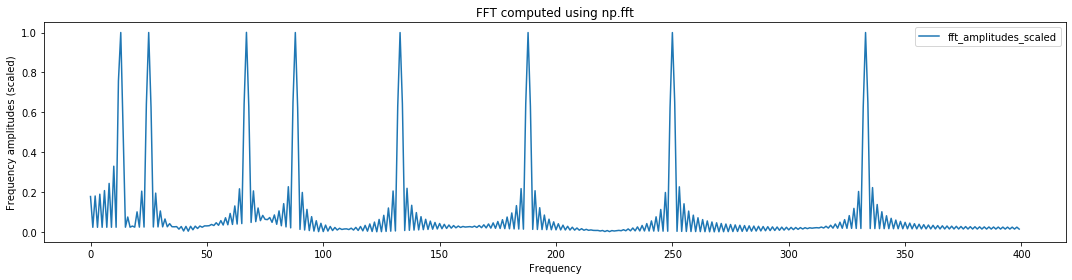

Num FFT freq bins: 400
FFT Freq bin spacing: 1.0
Found 9 freq peak(s) with a minimum amplitude of 0.3 at: 10.0, 13.0, 25.0, 67.0, 88.0, 133.0, 188.0, 250.0, 333.0 Hz
Freq and amplitudes: 10.0 Hz (0.33), 13.0 Hz (1.00), 25.0 Hz (1.00), 67.0 Hz (1.00), 88.0 Hz (1.00), 133.0 Hz (1.00), 188.0 Hz (1.00), 250.0 Hz (1.00), 333.0 Hz (1.00) Hz


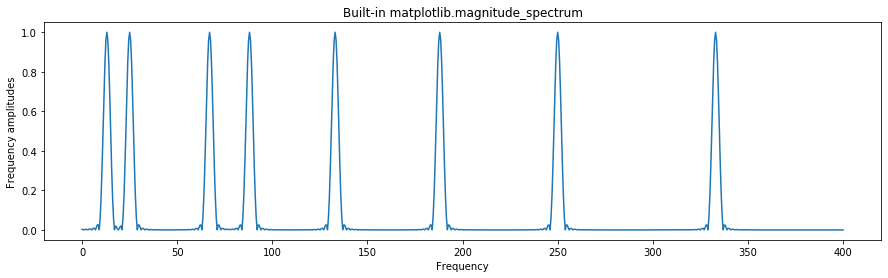

In [44]:
sampling_rate = 800
total_time_in_secs = 0.5
freqs = [13, 25, 67, 88, 133, 188, 250, 333] # add or change frequencies here
use_random_amplitudes = False # set to true to experiment with random amplitudes
s = makelab.signal.create_composite_sine_wave(freqs, sampling_rate, 
                               total_time_in_secs, 
                               use_random_amplitudes = use_random_amplitudes)
print(f"Created composite signal with frequencies: {freqs}")

fft_result = np.fft.fft(s, len(s) * 2)
num_freq_bins = len(fft_result)
fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
half_freq_bins = num_freq_bins // 2

fft_freqs = fft_freqs[:half_freq_bins]
fft_result = fft_result[:half_freq_bins]
fft_amplitudes = np.abs(fft_result)
fft_amplitudes_scaled = 2 * fft_amplitudes / (len(s))

plt.figure(figsize=(15,4))
plt.plot(fft_freqs, fft_amplitudes_scaled, label="fft_amplitudes_scaled")
plt.ylabel("Frequency amplitudes (scaled)")
plt.xlabel("Frequency")
plt.title("FFT computed using np.fft")
plt.legend()
plt.tight_layout()
plt.show()

minimum_freq_amplitude = 0.3
fft_peaks_indices, fft_peaks_props = sp.signal.find_peaks(fft_amplitudes_scaled, height = minimum_freq_amplitude)

fft_freq_peaks = fft_freqs[fft_peaks_indices]
fft_freq_peaks_amplitudes = fft_amplitudes_scaled[fft_peaks_indices]
fft_freq_peaks_csv = ", ".join(map(str, fft_freq_peaks))
fft_freq_peaks_with_amplitudes_csv = get_freq_and_amplitude_csv(fft_freq_peaks, fft_freq_peaks_amplitudes)

print(f"Num FFT freq bins: {len(fft_freqs)}")
print(f"FFT Freq bin spacing: {fft_freqs[1] - fft_freqs[0]}")
print(f"Found {len(fft_peaks_indices)} freq peak(s) with a minimum amplitude of {minimum_freq_amplitude} at: {fft_freq_peaks_csv} Hz")
print(f"Freq and amplitudes: {fft_freq_peaks_with_amplitudes_csv} Hz")

plt.figure(figsize=(15,4))
plt.magnitude_spectrum(s * 2, Fs = sampling_rate, pad_to = len(s) * 4)
plt.title("Built-in matplotlib.magnitude_spectrum")
plt.ylabel("Frequency amplitudes")
plt.show()

### Aliasing example

Recall from our [Quantization and Sampling Notebook](https://makeabilitylab.github.io/physcomp/signals/QuantizationAndSampling/index.html) that if we attempt to analyze a signal that contains frequencies beyond the Nyquist limit, we will get aliasing. In this case, a signal with 12,000Hz is aliased to 4,000Hz.

Text(0, 0.5, 'Frequency amplitudes')

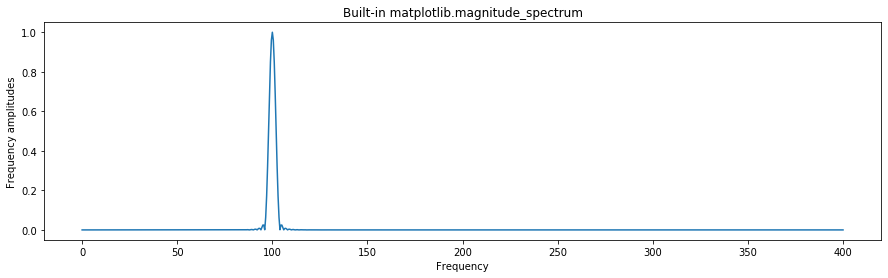

In [45]:
# freq = 1200 # Try changing this to anything 8,000Hz or beyond. What happens?
# total_time_in_secs = 0.5
# sampling_rate = 800
# s = makelab.signal.create_sine_wave(freq, sampling_rate, total_time_in_secs, return_time = False)

sampling_rate = 800
freq = 900 # feel free to change this
total_time_in_secs = 0.5

graph_title = f"Sine Wave with Freq={freq} Hz Time={total_time_in_secs:.2f}s Sampling Rate={sampling_rate}Hz"
s = makelab.signal.create_sine_wave(freq, sampling_rate, total_time_in_secs)

plt.figure(figsize=(15,4))
plt.magnitude_spectrum(s * 2, Fs = sampling_rate, pad_to = len(s) * 4)
plt.title("Built-in matplotlib.magnitude_spectrum")
plt.ylabel("Frequency amplitudes")


## Applying FFTs over time

The above analyses focused on computing DFTs across an entire signal. What if the signal changes substantially over time? 

Enter: the [Short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform).

### The Short-Time Fourier Transform and Spectrogram

As Wikipedia notes, "the STFT is a Fourier-related transform used to determine the sinusoidal frequency and phase content of local sections of a signal as it changes over time. In practice, the procedure for computing STFTs is to divide a longer time signal into shorter segments of equal length and then compute the Fourier transform separately on each shorter segment."

In short, the STFT works by performing a Fourier analysis using a sliding window. You can control the size of the sliding window (`NFFT`)and the overlap between each window (`nooverlap`).


### Resources
- [The Short-Time Fourier Transform (Jupyter Notebook)](https://colab.research.google.com/github/spatialaudio/digital-signal-processing-lecture/blob/master/spectral_analysis_deterministic_signals/stft.ipynb), Sascha Spors
- [Short-Time Fourier Transform (Jupyter Notebook)](https://musicinformationretrieval.com/stft.html), Steve Tjoa

### Analyzing Twinkle, Twinkle Little Star

Sampling rate: 8000 Hz
Number of channels = 1
Total samples: 60000
Length: 7.5 secs


C:\Users\jonfr\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7725: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


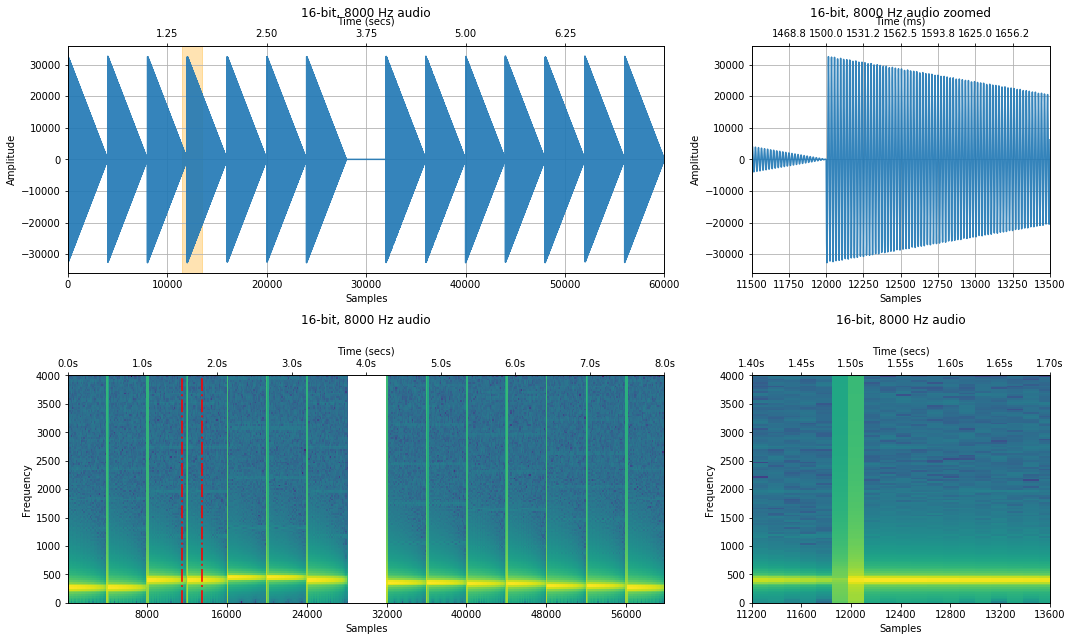

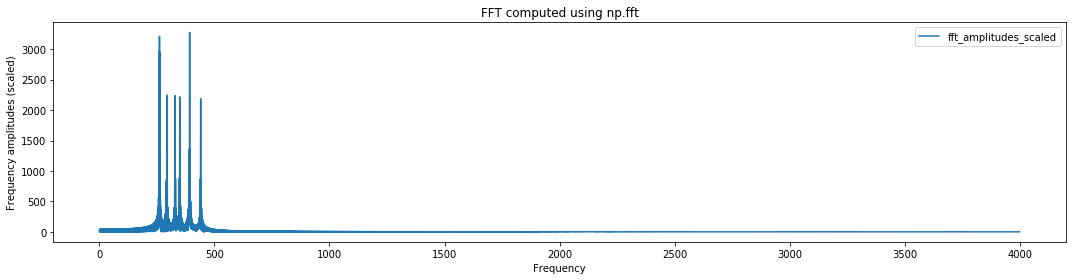

In [46]:
sampling_rate, freq_sweep = sp.io.wavfile.read('data/audio/SineWave_TwinkleTwinkle_SynthesizedXylophone_8kHz_mono_7.5secs.wav')

print(f"Sampling rate: {sampling_rate} Hz")
print(f"Number of channels = {len(freq_sweep.shape)}")
print(f"Total samples: {freq_sweep.shape[0]}")
print(f"Length: {len(freq_sweep) / sampling_rate} secs")

# Set a zoom area (a bit hard to see but highlighted in red in spectrogram)
xlim_zoom = (11500, 13500)
makelab.signal.plot_signal_and_spectrogram(freq_sweep, sampling_rate, 16, xlim_zoom = xlim_zoom)

fft_freqs, fft_amplitudes_scaled = compute_fft(freq_sweep, sampling_rate, n=len(freq_sweep) * 3)
plt.figure(figsize=(15,4))
plt.plot(fft_freqs, fft_amplitudes_scaled, label="fft_amplitudes_scaled")
plt.ylabel("Frequency amplitudes (scaled)")
plt.xlabel("Frequency")
plt.title("FFT computed using np.fft")
plt.legend()
plt.tight_layout()
plt.show()

minimum_freq_amplitude = 0.3
fft_peaks_indices, fft_peaks_props = sp.signal.find_peaks(fft_amplitudes_scaled, height = minimum_freq_amplitude)

fft_freq_peaks = fft_freqs[fft_peaks_indices]
fft_freq_peaks_amplitudes = fft_amplitudes_scaled[fft_peaks_indices]
fft_freq_peaks_csv = ", ".join(map(str, fft_freq_peaks))
fft_freq_peaks_with_amplitudes_csv = get_freq_and_amplitude_csv(fft_freq_peaks, fft_freq_peaks_amplitudes)

ipd.Audio(freq_sweep, rate=sampling_rate)

### Analyzing the C-scale

Note that when we synthesize this signal, we are created a linear amplitude dropoff between notes.

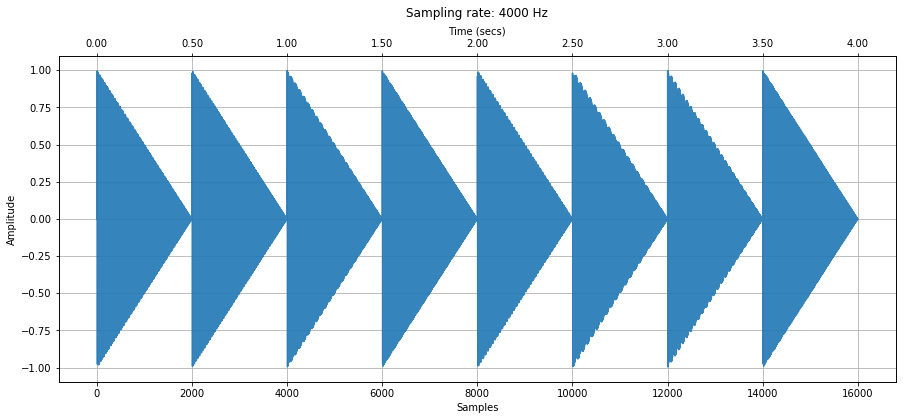

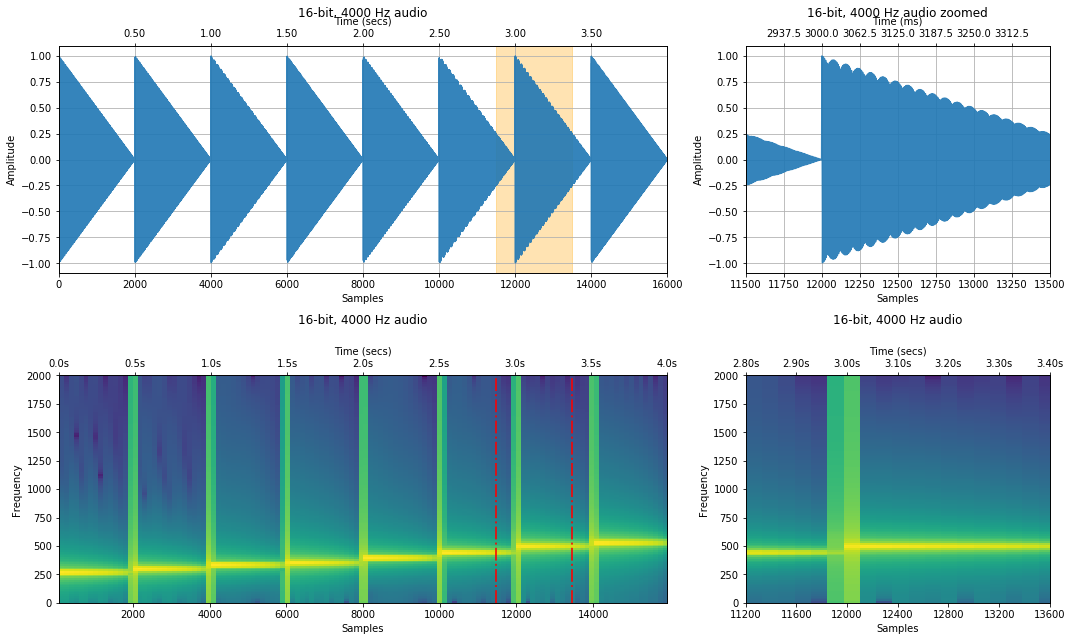

In [47]:
#twinkle_twinkle_freqs = [261.626, 261.626, 391.995, 391.995, 440, 440, 391.995]
c_scale_freqs = [261.626, 293.665, 329.628, 349.228, 391.995, 440, 493.883, 523.251] # c scale starting with middle c at 261.626
sampling_rate = 4000

signal_combined = makelab.signal.create_sine_wave_sequence(c_scale_freqs, sampling_rate, 0.5)
    
# plot_multiple_freq(c_scale, signal_combined, map_freq_to_signal, sampling_rate)
makelab.signal.plot_signal(signal_combined, sampling_rate)
makelab.signal.plot_signal_and_spectrogram(signal_combined, sampling_rate, 16, xlim_zoom = xlim_zoom)
ipd.Audio(signal_combined, rate=sampling_rate) 

## Jon Outline / Notes

Please ignore. These are my notes to myself when I'm writing and thinking about these notebooks.

- Find the O'Reilly book chapter (I recall it being relevant)
- Frequency analysis introduction (See http://localhost:8888/notebooks/Signals-FrequencyAnalysis.ipynb) for images. Also grab Gierad's sound paper (maybe other Gierad papers?)
- First: basic spectral analysis
- Second: spectrograms!
- Show C note from multiple instruments?
- Extracting top N frequencies
- Maybe show destructive summations (out of phase sine waves?)
- - Using autocorrelation for pitch detection: Chapter 5 of Allen B. Downey, [Think DSP: Digital Signal Processing in Python](http://greenteapress.com/thinkdsp/thinkdsp.pdf)?
- Talk about how to increase spectral resolution and padding?
- Talk about how FFT works fastest when N is a power of 2
- Maybe go over why it's a bad idea to simply zero out frequencies and use iDFT to obtain filtered signal:
    - https://poweidsplearningpath.blogspot.com/2019/04/dftidft.html
    - https://dsp.stackexchange.com/questions/6220/why-is-it-a-bad-idea-to-filter-by-zeroing-out-fft-bins
    - https://dsp.stackexchange.com/questions/6200/chop-out-frequencies-outside-human-hearing-range#comment10637_6202
- Possibly make a freq sweep animation. See: http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/
- Seamlessly transition between freqs:
    - https://dsp.stackexchange.com/questions/971/how-to-create-a-sine-wave-generator-that-can-smoothly-transition-between-frequen
- Spectrogram notes from ECE590 at Illinois: https://courses.engr.illinois.edu/ece590sip/sp2018/spectrograms1_wideband_narrowband.html
- Mathematics of music: http://www.stat.yale.edu/~zf59/MathematicsOfMusic.pdf

- Possible useful spectrogram resources for students?
    - https://www.dsprelated.com/freebooks/sasp/Short_Time_Fourier_Transform.html
    - https://www.dsprelated.com/freebooks/sasp/Classic_Spectrograms.html

- Possibly show freq analysis with step size of 0.1 or something
- Show inverse: extract freq and use this to create new signal
- Show how inverse can be used to create a simple freq-based filter?
- Possibly look at: http://sites.apam.columbia.edu/CTX/presentations/FFTs_Corrs.pdf
- What if sine wave has a y-axis offset? Then we need to subtract this out first: `fft = np.abs(np.fft.fft(signal - np.mean(signal)))`

### Jon Sandbox

The DFT takes in an $N$-point input signal and outputs **two** $N/2 + 1$ output signals, which contain the *amplitudes* of the component sine and cosine waves. The input signal is oftened referred to as in the **time domain** while the output signal is in the **frequency domain**.

<center><img src="assets/images/Figure8-3_TheDiscreteFourierTransform_StevenWSmithDSPGuide.png" width=700 alt="A diagram showing a time domain signal being transformed into two frequency domain signals corresponding to the amplitudes of the component sine and cosine waves in the time domain signal" style="margin: 10px"></center>
<center style="margin-left: 40px; margin-right: 40px"><small>A diagram showing a time domain signal being transformed into two frequency domain signals corresponding to the amplitudes of the component sine and cosine waves in the time domain signal. From <a href="http://www.dspguide.com/CH8.PDF">Smith's DSP Guide, Chapter 8: The Discrete Fourier Transform</a></small></center>